# Imports and Utilities

In [1]:
from typing import List, Tuple
import numpy as np
import pandas as pd
from IPython.display import Markdown
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, brier_score_loss, accuracy_score
from sklearn.model_selection import cross_val_score

COMPETITION_NAME = "march-machine-learning-mania-2023"
VERBOSE = True
SCORING = "neg_log_loss"

pd.set_option("display.max_columns", None)

def show_df(df: pd.DataFrame, name: str = "DataFrame", verbose: bool = VERBOSE):
    if verbose:
        display(Markdown(f"## {name}"))
        display(Markdown("### Head"))
        display(df.head())
        display(Markdown("### Tail"))
        display(df.tail())
        display(Markdown("### Description"))
        display(df.describe())


def extract_data(filename: str, competition_name:str = COMPETITION_NAME) -> pd.DataFrame:
    mens_filepath = f"/kaggle/input/{competition_name}/M{filename}.csv"
    womens_filepath = f"/kaggle/input/{competition_name}/W{filename}.csv"
    try:
        df_mens = pd.read_csv(mens_filepath)
    except FileNotFoundError:
        df_mens = None
    try:
        df_womens = pd.read_csv(womens_filepath)
    except FileNotFoundError:
        df_womens = None
    df = pd.concat([df_mens, df_womens])
    show_df(df, filename)
    return df


def get_team_features(detailed_results: pd.DataFrame) -> pd.DataFrame:
    df = detailed_results.copy()
    df = clean_detailed_results(df)
    df = transform_game_to_team(df)
    df = transform_team_results(df)
    show_df(df)
    return df


def get_seed_features(df_in: pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    mask = df["Season"] > 2015
    df = df[mask]
    df["Seed"] = df["Seed"].str.replace(r"\D+","", regex=True)
    df["Seed"] = df["Seed"].astype(int)
    show_df(df)
    return df


def get_ranking_features(df_in:pd.DataFrame) -> pd.DataFrame:
    df = df_in.copy()
    mask = df["RankingDayNum"] == df["RankingDayNum"].max()
    df = df[mask]
    df.drop(["SystemName", "RankingDayNum"], axis=1, inplace=True)
    df = df.groupby(["Season", "TeamID"]).agg("median")
    df = df.reset_index()
    show_df(df)
    return df


def get_game_outcomes(df):
    input_rows = df.to_records()
    output_rows = []
    for input_row in input_rows:
        output_rows.extend(parse_row(input_row))
    out_df = pd.DataFrame(output_rows)
    return out_df

def parse_row(row):
    season = row['Season']
    winning_team_id = row['WTeamID']
    losing_team_id = row['LTeamID']
    if winning_team_id < losing_team_id:
        small_id = winning_team_id
        big_id = losing_team_id
        outcome = True
    elif losing_team_id < winning_team_id:
        small_id = losing_team_id
        big_id = winning_team_id
        outcome = False
    records = [
        {
            "ID": f"{season}_{small_id}_{big_id}",
            'Season': season,
            'LowID': small_id,
            'HighID': big_id,
            'Win': outcome
        },
        {
            "ID": f"{season}_{big_id}_{small_id}",
            'Season': season,
            'LowID': big_id,
            'HighID': small_id,
            'Win': not outcome
        },
    ]
    return records


def clean_detailed_results(df: pd.DataFrame) -> pd.DataFrame:
    return df.drop(["WLoc", "DayNum"], axis=1)


def transform_game_to_team(game_results: pd.DataFrame) -> pd.DataFrame:
    winners = rename_columns(game_results, "W")
    loosers = rename_columns(game_results, "L")
    team_results = pd.concat((winners, loosers))
    team_results.drop(["TeamIDOpp"], axis=1, inplace=True)
    return team_results


def transform_team_results(df: pd.DataFrame) -> pd.DataFrame:
    df = df.groupby(["Season", "TeamID"]).median()
    df["FGP"] =  df["FGM"] / df["FGA"]
    df["FGP3"] =  df["FGM3"] / df["FGA3"]
    df["FTP"] =  df["FTM"] / df["FTA"]
    df["FGPOpp"] =  df["FGMOpp"] / df["FGAOpp"]
    df["FGP3Opp"] =  df["FGM3Opp"] / df["FGA3Opp"]
    df["FTPOpp"] =  df["FTMOpp"] / df["FTAOpp"]
    return df.reset_index()
    
    
def rename_columns(df: pd.DataFrame, team_prefix: str) -> pd.DataFrame:
    df = df.copy()
    df.columns =  (rename_column(column_name, team_prefix) for column_name in df.columns)
    return df


def rename_column(column_name: str, team_prefix: str) -> pd.DataFrame:
    if team_prefix == "W":
        opponent_prefix = "L"
    elif team_prefix == "L":
        opponent_prefix = "W"
    else:
        raise ValueError
    if column_name.startswith(team_prefix):
        column_name = column_name.lstrip(team_prefix)
    elif column_name.startswith(opponent_prefix):
        column_name = f"{column_name.lstrip(opponent_prefix)}Opp"
    return column_name


def split_winner_and_looser_columns(df: pd.DataFrame) -> Tuple[List[str], List[str]]:
    winner_columns = [name for name in df.columns if not name.startswith("L")]
    looser_columns = [name for name in df.columns if not name.startswith("W")]
    return winner_columns, looser_columns


def merge_features(
    season_features: pd.DataFrame, 
    tournament_features: pd.DataFrame, 
    seed_features: pd.DataFrame, 
    ranking_features: pd.DataFrame
) -> pd.DataFrame:
    features = pd.merge(
        season_features,
        tournament_features,
        how="left",
        on=["Season", "TeamID"],
        suffixes=("Reg", "Tou")
    )
    features = features.merge(
        seed_features,
        how="left",
        on=["Season", "TeamID"]
    )
    features = features.merge(
        ranking_features,
        how="left",
        on=["Season", "TeamID"],
    )
    show_df(features)
    return features


def merge_outcomes_with_features(outcomes: pd.DataFrame, features: pd.DataFrame, how: str = "inner") -> pd.DataFrame:
    feature_names = [name for name in features.columns if name not in ["Season", "TeamID", "Gender"]]
    data = pd.merge(
        outcomes, 
        features, 
        how=how, 
        left_on=["Season", "HighID"], 
        right_on=["Season", "TeamID"]
    )
    data = pd.merge(
        data, 
        features, 
        how=how, 
        left_on=["Season", "LowID"], 
        right_on=["Season", "TeamID"],
        suffixes=("High", "Low")
    )
    for name in feature_names:
        data[f"{name}Diff"] = data[f"{name}High"] - data[f"{name}Low"]
        data.drop([f"{name}High", f"{name}Low"], axis=1, inplace=True)
    data.drop(
        ["Season", "HighID", "LowID","TeamIDHigh","TeamIDLow"], 
        axis=1, 
        inplace=True
    )
    data.set_index("ID", inplace=True)
    data.fillna(value=0, inplace=True)
    show_df(data)
    return data


def get_submission_outcomes() -> pd.DataFrame:
    sample_submission = pd.read_csv(f"/kaggle/input/{COMPETITION_NAME}/SampleSubmission2023.csv")
    df = sample_submission.copy()
    df.drop("Pred", axis=1, inplace=True)
    df[["Season", "LowID", "HighID"]] = df["ID"].str.split("_", expand=True)
    df[["Season", "LowID", "HighID"]] = df[["Season", "LowID", "HighID"]].astype(int)
    show_df(df)
    return df


def objective(trial: optuna.Trial, X_train, y_train, scoring = SCORING):
    params = {
        "max_depth": trial.suggest_int('max_depth', 2, 32, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 4, 256, log=True)
    }

    model = train_model(params, X_train, y_train, scoring)
    score = np.mean(cross_val_score(model, X_train, y_train, scoring=scoring, cv=5))
    return score


def run_study(X_train, y_train):
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, X_train, y_train), n_trials=10)
    return study


def train_model(params, X, y, scoring):
    model = RandomForestClassifier(
        **params
    )
    model = model.fit(X, y)
    return model

# Load Data

In [2]:
season_results = extract_data("RegularSeasonDetailedResults")
tournament_results = extract_data("NCAATourneyDetailedResults")
seeds = extract_data("NCAATourneySeeds")
rankings = extract_data("MasseyOrdinals_thru_Season2023_Day128")

## RegularSeasonDetailedResults

### Head

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


### Tail

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
70778,2023,132,3179,89,3125,71,N,0,31,53,9,22,18,19,5,32,22,12,1,10,10,28,69,13,26,2,6,11,17,14,8,6,2,16
70779,2023,132,3221,66,3131,61,A,0,23,44,4,12,16,16,6,29,12,18,3,3,15,22,55,6,17,11,16,6,13,7,6,11,3,20
70780,2023,132,3235,61,3400,51,N,0,20,59,7,17,14,20,15,26,7,8,7,2,16,21,63,3,14,6,14,19,26,13,14,5,12,19
70781,2023,132,3284,80,3406,55,A,0,26,51,7,18,21,27,10,30,10,18,8,4,11,22,63,6,14,5,7,10,16,8,15,6,2,20
70782,2023,132,3357,72,3192,60,A,0,29,58,3,10,11,18,10,31,8,14,9,0,16,22,59,5,26,11,15,7,22,14,13,5,3,18


### Description

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
count,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000,178417.000000
mean,2014.470835,70.790289,2080.073620,73.994855,2077.227181,61.089061,0.062152,26.077672,56.898793,6.841590,18.535851,14.997921,21.068710,11.268635,26.179327,14.786130,13.716221,7.637400,3.749015,16.500810,21.980462,57.221582,5.672598,19.095355,11.455540,16.900396,11.076590,22.069764,11.221061,15.339934,6.445064,2.852946,18.657667
std,5.508945,35.774607,982.343183,11.380965,985.702305,11.355401,0.288673,4.800231,7.861990,3.145883,6.256778,6.123742,7.997068,4.489468,5.102352,4.508232,4.436845,3.486707,2.436574,4.715826,4.494163,7.804780,2.807538,6.297822,5.243352,7.003820,4.424222,4.716265,3.762809,5.012945,2.987407,2.042936,5.167583
min,2003.000000,0.000000,1101.000000,30.000000,1101.000000,11.000000,0.000000,9.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1.000000,1.000000,0.000000,0.000000,0.000000,3.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2011.000000,40.000000,1258.000000,66.000000,1250.000000,53.000000,0.000000,23.000000,52.000000,5.000000,14.000000,11.000000,15.000000,8.000000,23.000000,12.000000,11.000000,5.000000,2.000000,14.000000,19.000000,52.000000,4.000000,15.000000,8.000000,12.000000,8.000000,19.000000,9.000000,12.000000,4.000000,1.000000,16.000000
50%,2015.000000,75.000000,1407.000000,73.000000,1401.000000,61.000000,0.000000,26.000000,57.000000,7.000000,18.000000,15.000000,21.000000,11.000000,26.000000,14.000000,13.000000,7.000000,3.000000,17.000000,22.000000,57.000000,5.000000,19.000000,11.000000,16.000000,11.000000,22.000000,11.000000,15.000000,6.000000,3.000000,19.000000
75%,2019.000000,102.000000,3239.000000,81.000000,3239.000000,68.000000,0.000000,29.000000,62.000000,9.000000,22.000000,19.000000,26.000000,14.000000,29.000000,18.000000,16.000000,10.000000,5.000000,19.000000,25.000000,62.000000,7.000000,23.000000,15.000000,21.000000,14.000000,25.000000,14.000000,18.000000,8.000000,4.000000,22.000000
max,2023.000000,132.000000,3477.000000,149.000000,3477.000000,144.000000,6.000000,58.000000,113.000000,26.000000,58.000000,50.000000,67.000000,45.000000,58.000000,45.000000,40.000000,36.000000,21.000000,41.000000,53.000000,111.000000,25.000000,80.000000,42.000000,61.000000,38.000000,53.000000,34.000000,49.000000,26.000000,18.000000,47.000000


## NCAATourneyDetailedResults

### Head

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,134,1421,92,1411,84,N,1,32,69,11,29,17,26,14,30,17,12,5,3,22,29,67,12,31,14,31,17,28,16,15,5,0,22
1,2003,136,1112,80,1436,51,N,0,31,66,7,23,11,14,11,36,22,16,10,7,8,20,64,4,16,7,7,8,26,12,17,10,3,15
2,2003,136,1113,84,1272,71,N,0,31,59,6,14,16,22,10,27,18,9,7,4,19,25,69,7,28,14,21,20,22,11,12,2,5,18
3,2003,136,1141,79,1166,73,N,0,29,53,3,7,18,25,11,20,15,18,13,1,19,27,60,7,17,12,17,14,17,20,21,6,6,21
4,2003,136,1143,76,1301,74,N,1,27,64,7,20,15,23,18,20,17,13,8,2,14,25,56,9,21,15,20,10,26,16,14,5,8,19


### Tail

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
755,2022,147,3163,91,3301,87,N,2,37,77,5,21,12,20,12,23,10,7,5,2,16,32,66,7,23,16,19,6,30,20,13,4,7,16
756,2022,147,3257,62,3276,50,N,0,25,58,5,15,7,9,6,20,12,11,15,4,17,16,46,3,14,15,20,10,24,9,21,6,2,12
757,2022,151,3163,63,3390,58,N,0,21,57,5,14,16,20,12,30,14,19,5,2,16,23,66,4,23,8,13,11,23,10,11,11,3,16
758,2022,151,3376,72,3257,59,N,0,27,57,6,17,12,17,8,24,19,14,11,4,11,27,63,1,8,4,7,11,18,5,15,13,2,17
759,2022,153,3376,64,3163,49,N,0,22,60,3,16,17,26,18,23,9,14,6,4,11,22,54,4,16,1,4,3,16,14,14,4,5,21


### Description

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
count,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000,2008.000000
mean,2013.528386,139.710159,2045.650398,75.634462,2046.729582,62.015936,0.059761,26.939243,57.287351,6.655876,17.590637,15.100100,20.656873,11.247510,26.676793,14.885458,12.140936,6.912849,4.184263,15.668327,22.575199,58.981574,5.938247,20.037849,10.927291,15.542829,11.229582,21.421813,11.409363,13.059761,6.047809,2.977092,18.377490
std,5.278322,4.228837,969.483204,11.172242,970.123243,10.992444,0.268629,5.006453,7.628951,3.101281,6.027652,5.948663,7.566697,4.361469,5.312048,4.691566,4.148412,3.284223,2.649216,4.042198,4.386454,7.673206,2.828457,6.357993,5.144033,6.700226,4.469526,4.563548,3.690809,4.417929,2.866869,2.064595,4.235698
min,2003.000000,134.000000,1101.000000,47.000000,1101.000000,21.000000,0.000000,13.000000,34.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,3.000000,2.000000,0.000000,0.000000,3.000000,8.000000,37.000000,0.000000,3.000000,0.000000,0.000000,1.000000,8.000000,2.000000,2.000000,0.000000,0.000000,3.000000
25%,2010.000000,137.000000,1257.000000,68.000000,1266.000000,55.000000,0.000000,24.000000,52.000000,4.000000,13.000000,11.000000,15.000000,8.000000,23.000000,12.000000,9.000000,5.000000,2.000000,13.000000,20.000000,54.000000,4.000000,16.000000,7.000000,11.000000,8.000000,18.000000,9.000000,10.000000,4.000000,1.000000,15.000000
50%,2014.000000,138.000000,1403.000000,75.000000,1410.000000,62.000000,0.000000,27.000000,57.000000,6.000000,17.000000,15.000000,20.000000,11.000000,26.000000,15.000000,12.000000,6.000000,4.000000,15.000000,22.000000,59.000000,6.000000,20.000000,10.000000,15.000000,11.000000,21.000000,11.000000,13.000000,6.000000,3.000000,18.000000
75%,2018.000000,141.000000,3235.000000,83.000000,3234.250000,69.000000,0.000000,30.000000,62.000000,9.000000,21.000000,19.000000,25.000000,14.000000,30.000000,18.000000,15.000000,9.000000,6.000000,18.000000,26.000000,64.000000,8.000000,24.000000,14.000000,20.000000,14.000000,24.000000,14.000000,16.000000,8.000000,4.000000,21.000000
max,2022.000000,155.000000,3462.000000,140.000000,3462.000000,105.000000,2.000000,59.000000,91.000000,18.000000,41.000000,38.000000,48.000000,27.000000,54.000000,38.000000,34.000000,24.000000,16.000000,31.000000,38.000000,85.000000,18.000000,57.000000,31.000000,39.000000,29.000000,42.000000,29.000000,32.000000,22.000000,13.000000,33.000000


## NCAATourneySeeds

### Head

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


### Tail

,Season,Seed,TeamID
1603,2023,Z12,3405
1604,2023,Z13,3387
1605,2023,Z14,3241
1606,2023,Z15,3436
1607,2023,Z16,3151


### Description

,Season,TeamID
count,4098.000000,4098.000000
mean,2006.328697,2074.241825
std,10.320827,979.820612
min,1985.000000,1101.000000
25%,1999.000000,1266.000000
50%,2007.000000,1409.000000
75%,2015.000000,3243.000000
max,2023.000000,3464.000000


## MasseyOrdinals_thru_Season2023_Day128

### Head

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


### Tail

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
4922507,2023,128,WOL,1473,332
4922508,2023,128,WOL,1474,166
4922509,2023,128,WOL,1475,260
4922510,2023,128,WOL,1476,301
4922511,2023,128,WOL,1477,303


### Description

,Season,RankingDayNum,TeamID,OrdinalRank
count,4.922512e+06,4.922512e+06,4.922512e+06,4.922512e+06
mean,2.014509e+03,8.579581e+01,1.285106e+03,1.729623e+02
std,5.585556e+00,3.264455e+01,1.047975e+02,1.010574e+02
min,2.003000e+03,0.000000e+00,1.101000e+03,1.000000e+00
25%,2.010000e+03,5.800000e+01,1.194000e+03,8.500000e+01
50%,2.015000e+03,9.100000e+01,1.284000e+03,1.730000e+02
75%,2.019000e+03,1.140000e+02,1.376000e+03,2.600000e+02
max,2.023000e+03,1.330000e+02,1.477000e+03,3.630000e+02


# Transform Data

In [3]:
season_team_features = get_team_features(season_results)

tournament_results["Season"] += 1
tournament_team_features = get_team_features(tournament_results)

seed_features = get_seed_features(seeds)

ranking_features = get_ranking_features(rankings)

## DataFrame

### Head

,Season,TeamID,Score,ScoreOpp,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,FGMOpp,FGAOpp,FGM3Opp,FGA3Opp,FTMOpp,FTAOpp,OROpp,DROpp,AstOpp,TOOpp,StlOpp,BlkOpp,PFOpp,FGP,FGP3,FTP,FGPOpp,FGP3Opp,FTPOpp
0,2003,1102,56.5,58.5,0.0,19.0,40.0,7.0,20.0,10.0,17.0,4.5,17.0,12.0,11.0,5.5,1.0,19.0,19.0,42.0,4.0,11.0,14.0,20.0,9.0,19.0,8.0,13.5,5.0,1.0,18.0,0.475000,0.350000,0.588235,0.452381,0.363636,0.700000
1,2003,1103,79.0,77.0,0.0,28.0,56.0,4.0,14.0,18.0,25.0,10.0,20.0,16.0,13.0,8.0,2.0,19.0,28.0,56.0,6.0,18.0,15.0,20.0,12.0,20.0,16.0,15.0,6.0,3.0,21.0,0.500000,0.285714,0.720000,0.500000,0.333333,0.750000
2,2003,1104,69.0,63.5,0.0,24.0,57.5,7.0,20.0,15.0,20.0,13.0,24.0,13.0,13.0,6.0,4.0,18.0,23.0,54.5,6.0,19.5,12.0,16.5,10.0,22.5,11.0,14.0,6.0,3.0,19.0,0.417391,0.350000,0.750000,0.422018,0.307692,0.727273
3,2003,1105,71.5,78.5,0.0,25.0,61.5,8.0,21.0,14.0,21.5,14.0,23.5,15.0,18.0,9.0,2.0,20.0,27.0,58.5,6.0,18.0,17.5,27.0,13.0,26.0,15.0,19.0,9.5,4.0,19.0,0.406504,0.380952,0.651163,0.461538,0.333333,0.648148
4,2003,1106,60.5,63.5,0.0,22.5,54.5,6.0,18.0,10.0,16.5,11.5,23.5,11.0,16.5,8.5,3.0,18.0,22.0,52.0,4.0,13.0,14.5,21.5,12.0,21.5,11.5,15.0,8.0,2.0,16.0,0.412844,0.333333,0.606061,0.423077,0.307692,0.674419


### Tail

,Season,TeamID,Score,ScoreOpp,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,FGMOpp,FGAOpp,FGM3Opp,FGA3Opp,FTMOpp,FTAOpp,OROpp,DROpp,AstOpp,TOOpp,StlOpp,BlkOpp,PFOpp,FGP,FGP3,FTP,FGPOpp,FGP3Opp,FTPOpp
12130,2023,3473,56.0,71.0,0.0,21.0,51.0,7.0,21.0,8.0,13.0,6.0,19.0,12.0,19.0,6.0,2.0,16.0,27.0,61.0,5.0,17.0,11.0,17.0,10.0,21.0,13.0,13.0,11.0,2.0,17.0,0.411765,0.333333,0.615385,0.442623,0.294118,0.647059
12131,2023,3474,57.5,73.0,0.0,20.0,58.5,4.0,15.0,12.5,17.5,8.0,20.0,7.0,14.0,7.0,2.0,21.5,24.5,55.5,5.0,14.5,16.0,24.0,9.5,28.0,14.0,17.0,6.0,3.0,18.5,0.341880,0.266667,0.714286,0.441441,0.344828,0.666667
12132,2023,3475,59.5,63.0,0.0,21.0,55.5,4.0,16.0,15.0,19.0,9.0,24.0,13.0,20.5,7.0,2.0,19.0,22.0,56.0,7.0,22.5,14.0,21.5,9.0,20.5,12.0,16.0,11.0,3.0,20.0,0.378378,0.250000,0.789474,0.392857,0.311111,0.651163
12133,2023,3476,61.0,66.0,0.0,22.0,56.5,6.0,21.0,9.5,12.0,9.0,21.0,13.5,14.5,3.0,3.0,14.0,26.0,57.5,5.0,14.0,10.5,15.0,8.0,22.0,12.0,11.0,7.0,3.0,15.5,0.389381,0.285714,0.791667,0.452174,0.357143,0.700000
12134,2023,3477,64.5,70.5,0.0,22.0,58.0,3.5,14.0,14.5,21.0,11.0,23.0,11.0,16.0,7.5,3.0,15.0,27.0,60.5,7.0,19.0,10.5,13.5,9.0,23.5,15.0,16.0,8.0,4.0,19.0,0.379310,0.250000,0.690476,0.446281,0.368421,0.777778


### Description

,Season,TeamID,Score,ScoreOpp,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,FGMOpp,FGAOpp,FGM3Opp,FGA3Opp,FTMOpp,FTAOpp,OROpp,DROpp,AstOpp,TOOpp,StlOpp,BlkOpp,PFOpp,FGP,FGP3,FTP,FGPOpp,FGP3Opp,FTPOpp
count,12135.000000,12135.000000,12135.000000,12135.000000,12135.0,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000
mean,2014.517017,2089.380058,67.139637,67.268150,0.0,23.830614,56.796580,6.057932,18.552081,12.713473,18.401030,10.859044,23.909188,12.740915,14.326288,6.826370,3.034487,17.206263,23.873548,56.790111,6.037577,18.487227,12.772806,18.514874,10.868150,23.978368,12.757272,14.330119,6.802637,2.978492,17.158426,0.419911,0.324527,0.692140,0.420766,0.325754,0.691020
std,5.575842,986.374172,7.005626,6.474942,0.0,2.528029,3.997549,1.644145,3.998332,2.421280,3.297962,2.358745,2.301452,2.098420,2.517056,1.659273,1.141354,3.614018,2.411576,3.974644,1.330590,3.129374,2.485886,3.492346,2.045561,2.424619,1.952139,2.605212,1.430014,0.756293,3.470759,0.037179,0.044527,0.060765,0.035292,0.041183,0.052087
min,2003.000000,1101.000000,38.500000,44.000000,0.0,13.000000,39.000000,0.000000,3.000000,4.500000,6.500000,3.000000,15.000000,5.000000,7.000000,3.000000,0.000000,0.000000,15.000000,39.000000,2.000000,8.000000,4.000000,6.500000,4.000000,15.000000,6.000000,6.500000,2.000000,1.000000,0.000000,0.275862,0.000000,0.457143,0.277778,0.157895,0.470588
25%,2011.000000,1255.000000,62.500000,63.000000,0.0,22.000000,54.000000,5.000000,16.000000,11.000000,16.000000,9.000000,22.000000,11.000000,12.500000,6.000000,2.000000,16.000000,22.000000,54.000000,5.000000,16.000000,11.000000,16.000000,9.500000,22.000000,11.500000,12.500000,6.000000,2.500000,16.000000,0.396226,0.294118,0.650000,0.396552,0.300000,0.656250
50%,2015.000000,1406.000000,67.000000,67.000000,0.0,24.000000,57.000000,6.000000,18.000000,13.000000,18.000000,11.000000,24.000000,13.000000,14.000000,7.000000,3.000000,18.000000,24.000000,57.000000,6.000000,18.500000,13.000000,18.000000,11.000000,24.000000,13.000000,14.000000,7.000000,3.000000,18.000000,0.421053,0.326531,0.690476,0.421053,0.325581,0.689655
75%,2019.000000,3242.000000,72.000000,71.500000,0.0,25.500000,59.000000,7.000000,21.000000,14.000000,20.500000,12.000000,25.000000,14.000000,16.000000,8.000000,4.000000,19.000000,25.500000,59.500000,7.000000,20.500000,14.000000,21.000000,12.000000,25.500000,14.000000,16.000000,8.000000,3.000000,19.000000,0.446429,0.352941,0.733333,0.444444,0.352941,0.725000
max,2023.000000,3477.000000,99.000000,99.000000,0.0,36.000000,81.000000,13.500000,41.500000,22.000000,31.000000,22.000000,34.000000,23.500000,28.000000,16.000000,9.000000,28.000000,36.500000,75.000000,12.000000,31.000000,23.000000,35.000000,19.000000,35.000000,22.000000,28.000000,15.000000,6.500000,26.000000,0.562500,0.500000,1.000000,0.547170,0.478261,0.916667


## DataFrame

### Head

,Season,TeamID,Score,ScoreOpp,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,FGMOpp,FGAOpp,FGM3Opp,FGA3Opp,FTMOpp,FTAOpp,OROpp,DROpp,AstOpp,TOOpp,StlOpp,BlkOpp,PFOpp,FGP,FGP3,FTP,FGPOpp,FGP3Opp,FTPOpp
0,2004,1104,62.0,67.0,0.0,22.0,52.0,5.0,12.0,13.0,16.0,9.0,20.0,13.0,8.0,2.0,6.0,21.0,19.0,49.0,7.0,18.0,22.0,26.0,13.0,22.0,15.0,8.0,1.0,2.0,17.0,0.423077,0.416667,0.812500,0.387755,0.388889,0.846154
1,2004,1112,84.0,74.5,0.0,32.5,70.0,7.0,22.5,15.0,18.5,12.5,29.5,18.5,13.0,9.0,4.5,17.0,27.0,65.5,9.0,24.5,11.5,18.0,12.0,26.5,15.5,16.0,8.0,4.5,18.0,0.464286,0.311111,0.810811,0.412214,0.367347,0.638889
2,2004,1113,80.0,89.5,0.0,29.5,64.0,5.0,14.5,16.0,22.5,13.5,20.5,14.5,10.0,7.0,4.5,20.0,32.5,64.0,6.0,18.5,18.5,27.5,16.0,25.0,16.0,12.5,4.0,5.5,19.0,0.460938,0.344828,0.711111,0.507812,0.324324,0.672727
3,2004,1120,68.0,63.0,0.0,25.0,57.0,7.0,19.0,14.0,17.0,14.0,24.0,11.0,15.0,5.0,5.0,18.0,22.0,59.0,6.0,23.0,16.0,21.0,15.0,21.0,11.0,12.0,8.0,7.0,19.0,0.438596,0.368421,0.823529,0.372881,0.260870,0.761905
4,2004,1122,64.0,86.0,0.0,24.0,54.0,2.0,21.0,14.0,22.0,8.0,21.0,11.0,18.0,5.0,3.0,18.0,35.0,70.0,8.0,24.0,8.0,13.0,15.0,29.0,18.0,12.0,12.0,4.0,22.0,0.444444,0.095238,0.636364,0.500000,0.333333,0.615385


### Tail

,Season,TeamID,Score,ScoreOpp,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,FGMOpp,FGAOpp,FGM3Opp,FGA3Opp,FTMOpp,FTAOpp,OROpp,DROpp,AstOpp,TOOpp,StlOpp,BlkOpp,PFOpp,FGP,FGP3,FTP,FGPOpp,FGP3Opp,FTPOpp
2034,2023,3426,71.0,78.0,0.0,27.0,62.0,7.0,16.0,10.0,16.0,7.0,26.0,11.0,9.0,6.0,5.0,20.0,28.0,65.0,7.0,20.0,15.0,26.0,11.0,27.0,6.0,7.0,2.0,6.0,14.0,0.435484,0.437500,0.625000,0.430769,0.350000,0.576923
2035,2023,3428,74.0,73.5,0.0,27.5,53.5,10.5,25.5,8.5,12.0,6.0,25.5,16.5,17.5,3.0,1.5,14.5,31.5,67.0,3.5,14.5,7.0,12.5,9.5,18.5,10.5,8.5,9.0,4.5,12.0,0.514019,0.411765,0.708333,0.470149,0.241379,0.560000
2036,2023,3437,55.0,60.5,0.0,20.5,58.5,6.0,23.5,8.0,12.0,7.5,19.5,11.0,10.0,8.5,5.0,18.0,22.5,55.5,4.0,15.0,11.5,16.5,11.5,29.5,12.5,15.0,7.0,1.0,12.5,0.350427,0.255319,0.666667,0.405405,0.266667,0.696970
2037,2023,3439,81.0,84.0,0.0,30.0,60.0,6.0,17.0,15.0,20.0,7.0,28.0,13.0,10.0,1.0,1.0,13.0,30.0,64.0,15.0,38.0,9.0,11.0,2.0,25.0,19.0,3.0,7.0,1.0,18.0,0.500000,0.352941,0.750000,0.468750,0.394737,0.818182
2038,2023,3450,40.0,50.0,0.0,14.0,56.0,3.0,22.0,9.0,14.0,8.0,31.0,5.0,17.0,2.0,2.0,23.0,14.0,53.0,3.0,14.0,19.0,22.0,6.0,30.0,7.0,11.0,6.0,3.0,11.0,0.250000,0.136364,0.642857,0.264151,0.214286,0.863636


### Description

,Season,TeamID,Score,ScoreOpp,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,FGMOpp,FGAOpp,FGM3Opp,FGA3Opp,FTMOpp,FTAOpp,OROpp,DROpp,AstOpp,TOOpp,StlOpp,BlkOpp,PFOpp,FGP,FGP3,FTP,FGPOpp,FGP3Opp,FTPOpp
count,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2034.000000,2039.000000,2039.000000,2039.000000
mean,2014.527710,2046.475233,65.795733,71.248651,0.044385,23.690289,58.164787,6.191761,19.493624,12.066699,16.991663,11.010790,23.017656,12.389897,12.862678,6.255272,3.210888,17.558117,25.492889,57.678274,6.413683,18.403139,13.780284,19.081658,11.146886,25.198382,13.824669,12.497793,6.660128,3.716528,16.486513,0.409195,0.317894,0.707800,0.443377,0.347492,0.721345
std,5.278327,970.130845,10.973542,10.781484,0.210999,4.269685,6.814759,2.519504,5.868360,4.810207,6.198700,3.882806,4.467820,3.571197,3.860042,2.650049,1.989462,3.780883,4.556894,6.831167,2.614109,5.354628,5.205684,6.701129,3.828945,5.096276,4.119270,3.794768,2.811066,2.239593,3.641293,0.068118,0.093978,0.119369,0.066956,0.101380,0.104148
min,2004.000000,1101.000000,29.000000,40.000000,0.000000,8.000000,37.000000,0.000000,3.000000,0.000000,0.000000,1.000000,8.000000,2.000000,2.000000,0.000000,0.000000,7.000000,13.000000,37.000000,0.000000,3.000000,0.000000,1.000000,0.000000,10.000000,3.000000,3.000000,0.000000,0.000000,3.000000,0.137931,0.000000,0.000000,0.260163,0.000000,0.000000
25%,2011.000000,1265.000000,59.000000,64.000000,0.000000,21.000000,54.000000,4.000000,15.500000,9.000000,13.000000,8.000000,20.000000,10.000000,10.000000,4.500000,2.000000,15.000000,22.000000,53.000000,4.500000,15.000000,10.000000,14.000000,8.500000,22.000000,11.000000,10.000000,5.000000,2.000000,14.000000,0.365301,0.257143,0.642857,0.396226,0.277778,0.657519
50%,2015.000000,1409.000000,66.500000,70.000000,0.000000,24.000000,58.000000,6.000000,19.000000,12.000000,17.000000,11.000000,23.000000,12.000000,12.500000,6.000000,3.000000,17.000000,25.000000,57.500000,6.000000,18.000000,13.000000,18.000000,11.000000,24.500000,13.000000,12.000000,6.000000,3.000000,16.500000,0.413223,0.318182,0.714286,0.440000,0.341463,0.727273
75%,2019.000000,3234.000000,73.000000,78.000000,0.000000,26.500000,62.500000,8.000000,23.000000,15.000000,21.000000,13.500000,26.000000,15.000000,15.000000,8.000000,4.000000,20.000000,28.000000,62.000000,8.000000,22.000000,17.000000,23.000000,13.500000,28.000000,16.000000,15.000000,8.000000,5.000000,19.000000,0.457627,0.380952,0.785714,0.486726,0.409674,0.789474
max,2023.000000,3462.000000,100.000000,140.000000,2.000000,37.000000,85.000000,16.000000,57.000000,31.000000,42.000000,29.000000,42.000000,29.000000,32.000000,22.000000,13.000000,33.000000,59.000000,91.000000,16.000000,40.000000,38.000000,48.000000,27.000000,54.000000,38.000000,32.000000,24.000000,15.000000,29.000000,0.621359,0.666667,1.000000,0.701754,0.750000,1.000000


## DataFrame

### Head

,Season,Seed,TeamID
2014,2016,1,1314
2015,2016,2,1462
2016,2016,3,1452
2017,2016,4,1246
2018,2016,5,1231


### Tail

,Season,Seed,TeamID
1603,2023,12,3405
1604,2023,13,3387
1605,2023,14,3241
1606,2023,15,3436
1607,2023,16,3151


### Description

,Season,Seed,TeamID
count,932.000000,932.000000,932.000000
mean,2019.454936,8.694206,2265.305794
std,2.448855,4.650612,998.553262
min,2016.000000,1.000000,1101.000000
25%,2017.000000,5.000000,1286.000000
50%,2019.000000,9.000000,1459.500000
75%,2022.000000,13.000000,3274.500000
max,2023.000000,16.000000,3461.000000


## DataFrame

### Head

,Season,TeamID,OrdinalRank
0,2003,1102,156.0
1,2003,1103,170.5
2,2003,1104,37.0
3,2003,1105,310.0
4,2003,1106,265.5


### Tail

,Season,TeamID,OrdinalRank
6533,2022,1468,188.0
6534,2022,1469,272.0
6535,2022,1470,225.0
6536,2022,1471,263.0
6537,2022,1472,312.5


### Description

,Season,TeamID,OrdinalRank
count,6538.000000,6538.000000,6538.000000
mean,2012.237381,1284.724075,172.433848
std,5.627648,104.698854,98.908163
min,2003.000000,1101.000000,1.000000
25%,2007.000000,1194.000000,87.000000
50%,2012.000000,1283.500000,172.000000
75%,2017.000000,1376.000000,257.000000
max,2022.000000,1472.000000,358.000000


## Merge features

In [4]:
features = merge_features(season_team_features, tournament_team_features, seed_features, ranking_features)

## DataFrame

### Head

,Season,TeamID,ScoreReg,ScoreOppReg,NumOTReg,FGMReg,FGAReg,FGM3Reg,FGA3Reg,FTMReg,FTAReg,ORReg,DRReg,AstReg,TOReg,StlReg,BlkReg,PFReg,FGMOppReg,FGAOppReg,FGM3OppReg,FGA3OppReg,FTMOppReg,FTAOppReg,OROppReg,DROppReg,AstOppReg,TOOppReg,StlOppReg,BlkOppReg,PFOppReg,FGPReg,FGP3Reg,FTPReg,FGPOppReg,FGP3OppReg,FTPOppReg,ScoreTou,ScoreOppTou,NumOTTou,FGMTou,FGATou,FGM3Tou,FGA3Tou,FTMTou,FTATou,ORTou,DRTou,AstTou,TOTou,StlTou,BlkTou,PFTou,FGMOppTou,FGAOppTou,FGM3OppTou,FGA3OppTou,FTMOppTou,FTAOppTou,OROppTou,DROppTou,AstOppTou,TOOppTou,StlOppTou,BlkOppTou,PFOppTou,FGPTou,FGP3Tou,FTPTou,FGPOppTou,FGP3OppTou,FTPOppTou,Seed,OrdinalRank
0,2003,1102,56.5,58.5,0.0,19.0,40.0,7.0,20.0,10.0,17.0,4.5,17.0,12.0,11.0,5.5,1.0,19.0,19.0,42.0,4.0,11.0,14.0,20.0,9.0,19.0,8.0,13.5,5.0,1.0,18.0,0.475000,0.350000,0.588235,0.452381,0.363636,0.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.0
1,2003,1103,79.0,77.0,0.0,28.0,56.0,4.0,14.0,18.0,25.0,10.0,20.0,16.0,13.0,8.0,2.0,19.0,28.0,56.0,6.0,18.0,15.0,20.0,12.0,20.0,16.0,15.0,6.0,3.0,21.0,0.500000,0.285714,0.720000,0.500000,0.333333,0.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,170.5
2,2003,1104,69.0,63.5,0.0,24.0,57.5,7.0,20.0,15.0,20.0,13.0,24.0,13.0,13.0,6.0,4.0,18.0,23.0,54.5,6.0,19.5,12.0,16.5,10.0,22.5,11.0,14.0,6.0,3.0,19.0,0.417391,0.350000,0.750000,0.422018,0.307692,0.727273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0
3,2003,1105,71.5,78.5,0.0,25.0,61.5,8.0,21.0,14.0,21.5,14.0,23.5,15.0,18.0,9.0,2.0,20.0,27.0,58.5,6.0,18.0,17.5,27.0,13.0,26.0,15.0,19.0,9.5,4.0,19.0,0.406504,0.380952,0.651163,0.461538,0.333333,0.648148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310.0
4,2003,1106,60.5,63.5,0.0,22.5,54.5,6.0,18.0,10.0,16.5,11.5,23.5,11.0,16.5,8.5,3.0,18.0,22.0,52.0,4.0,13.0,14.5,21.5,12.0,21.5,11.5,15.0,8.0,2.0,16.0,0.412844,0.333333,0.606061,0.423077,0.307692,0.674419,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,265.5


### Tail

,Season,TeamID,ScoreReg,ScoreOppReg,NumOTReg,FGMReg,FGAReg,FGM3Reg,FGA3Reg,FTMReg,FTAReg,ORReg,DRReg,AstReg,TOReg,StlReg,BlkReg,PFReg,FGMOppReg,FGAOppReg,FGM3OppReg,FGA3OppReg,FTMOppReg,FTAOppReg,OROppReg,DROppReg,AstOppReg,TOOppReg,StlOppReg,BlkOppReg,PFOppReg,FGPReg,FGP3Reg,FTPReg,FGPOppReg,FGP3OppReg,FTPOppReg,ScoreTou,ScoreOppTou,NumOTTou,FGMTou,FGATou,FGM3Tou,FGA3Tou,FTMTou,FTATou,ORTou,DRTou,AstTou,TOTou,StlTou,BlkTou,PFTou,FGMOppTou,FGAOppTou,FGM3OppTou,FGA3OppTou,FTMOppTou,FTAOppTou,OROppTou,DROppTou,AstOppTou,TOOppTou,StlOppTou,BlkOppTou,PFOppTou,FGPTou,FGP3Tou,FTPTou,FGPOppTou,FGP3OppTou,FTPOppTou,Seed,OrdinalRank
12130,2023,3473,56.0,71.0,0.0,21.0,51.0,7.0,21.0,8.0,13.0,6.0,19.0,12.0,19.0,6.0,2.0,16.0,27.0,61.0,5.0,17.0,11.0,17.0,10.0,21.0,13.0,13.0,11.0,2.0,17.0,0.411765,0.333333,0.615385,0.442623,0.294118,0.647059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12131,2023,3474,57.5,73.0,0.0,20.0,58.5,4.0,15.0,12.5,17.5,8.0,20.0,7.0,14.0,7.0,2.0,21.5,24.5,55.5,5.0,14.5,16.0,24.0,9.5,28.0,14.0,17.0,6.0,3.0,18.5,0.341880,0.266667,0.714286,0.441441,0.344828,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12132,2023,3475,59.5,63.0,0.0,21.0,55.5,4.0,16.0,15.0,19.0,9.0,24.0,13.0,20.5,7.0,2.0,19.0,22.0,56.0,7.0,22.5,14.0,21.5,9.0,20.5,12.0,16.0,11.0,3.0,20.0,0.378378,0.250000,0.789474,0.392857,0.311111,0.651163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12133,2023,3476,61.0,66.0,0.0,22.0,56.5,6.0,21.0,9.5,12.0,9.0,21.0,13.5,14.5,3.0,3.0,14.0,26.0,57.5,5.0,14.0,10.5,15.0,8.0,22.0,12.0,11.0,7.0,3.0,15.5,0.389381,0.285714,0.791667,0.452174,0.357143,0.700000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12134,2023,3477,64.5,70.5,0.0,22.0,58.0,3.5,14.0,14.5,21.0,11.0,23.0,11.0,16.0,7.5,3.0,15.0,27.0,60.5,7.0,19.0,10.5,13.5,9.0,23.5,15.0,16.0,8.0,4.0,19.0,0.379310,0.250000,0.690476,0.446281,0.368421,0.777778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Description

,Season,TeamID,ScoreReg,ScoreOppReg,NumOTReg,FGMReg,FGAReg,FGM3Reg,FGA3Reg,FTMReg,FTAReg,ORReg,DRReg,AstReg,TOReg,StlReg,BlkReg,PFReg,FGMOppReg,FGAOppReg,FGM3OppReg,FGA3OppReg,FTMOppReg,FTAOppReg,OROppReg,DROppReg,AstOppReg,TOOppReg,StlOppReg,BlkOppReg,PFOppReg,FGPReg,FGP3Reg,FTPReg,FGPOppReg,FGP3OppReg,FTPOppReg,ScoreTou,ScoreOppTou,NumOTTou,FGMTou,FGATou,FGM3Tou,FGA3Tou,FTMTou,FTATou,ORTou,DRTou,AstTou,TOTou,StlTou,BlkTou,PFTou,FGMOppTou,FGAOppTou,FGM3OppTou,FGA3OppTou,FTMOppTou,FTAOppTou,OROppTou,DROppTou,AstOppTou,TOOppTou,StlOppTou,BlkOppTou,PFOppTou,FGPTou,FGP3Tou,FTPTou,FGPOppTou,FGP3OppTou,FTPOppTou,Seed,OrdinalRank
count,12135.000000,12135.000000,12135.000000,12135.000000,12135.0,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,12135.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2039.000000,2034.000000,2039.000000,2039.000000,2039.000000,932.000000,6538.000000
mean,2014.517017,2089.380058,67.139637,67.268150,0.0,23.830614,56.796580,6.057932,18.552081,12.713473,18.401030,10.859044,23.909188,12.740915,14.326288,6.826370,3.034487,17.206263,23.873548,56.790111,6.037577,18.487227,12.772806,18.514874,10.868150,23.978368,12.757272,14.330119,6.802637,2.978492,17.158426,0.419911,0.324527,0.692140,0.420766,0.325754,0.691020,65.795733,71.248651,0.044385,23.690289,58.164787,6.191761,19.493624,12.066699,16.991663,11.010790,23.017656,12.389897,12.862678,6.255272,3.210888,17.558117,25.492889,57.678274,6.413683,18.403139,13.780284,19.081658,11.146886,25.198382,13.824669,12.497793,6.660128,3.716528,16.486513,0.409195,0.317894,0.707800,0.443377,0.347492,0.721345,8.694206,172.433848
std,5.575842,986.374172,7.005626,6.474942,0.0,2.528029,3.997549,1.644145,3.998332,2.421280,3.297962,2.358745,2.301452,2.098420,2.517056,1.659273,1.141354,3.614018,2.411576,3.974644,1.330590,3.129374,2.485886,3.492346,2.045561,2.424619,1.952139,2.605212,1.430014,0.756293,3.470759,0.037179,0.044527,0.060765,0.035292,0.041183,0.052087,10.973542,10.781484,0.210999,4.269685,6.814759,2.519504,5.868360,4.810207,6.198700,3.882806,4.467820,3.571197,3.860042,2.650049,1.989462,3.780883,4.556894,6.831167,2.614109,5.354628,5.205684,6.701129,3.828945,5.096276,4.119270,3.794768,2.811066,2.239593,3.641293,0.068118,0.093978,0.119369,0.066956,0.101380,0.104148,4.650612,98.908163
min,2003.000000,1101.000000,38.500000,44.000000,0.0,13.000000,39.000000,0.000000,3.000000,4.500000,6.500000,3.000000,15.000000,5.000000,7.000000,3.000000,0.000000,0.000000,15.000000,39.000000,2.000000,8.000000,4.000000,6.500000,4.000000,15.000000,6.000000,6.500000,2.000000,1.000000,0.000000,0.275862,0.000000,0.457143,0.277778,0.157895,0.470588,29.000000,40.000000,0.000000,8.000000,37.000000,0.000000,3.000000,0.000000,0.000000,1.000000,8.000000,2.000000,2.000000,0.000000,0.000000,7.000000,13.000000,37.000000,0.000000,3.000000,0.000000,1.000000,0.000000,10.000000,3.000000,3.000000,0.000000,0.000000,3.000000,0.137931,0.000000,0.000000,0.260163,0.000000,0.000000,1.000000,1.000000
25%,2011.000000,1255.000000,62.500000,63.000000,0.0,22.000000,54.000000,5.000000,16.000000,11.000000,16.000000,9.000000,22.000000,11.000000,12.500000,6.000000,2.000000,16.000000,22.000000,54.000000,5.000000,16.000000,11.000000,16.000000,9.500000,22.000000,11.500000,12.500000,6.000000,2.500000,16.000000,0.396226,0.294118,0.650000,0.396552,0.300000,0.656250,59.000000,64

## Build Datasets

In [5]:
from sklearn.model_selection import train_test_split

data = pd.concat([extract_data("NCAATourneyCompactResults"), extract_data("RegularSeasonCompactResults")])
data_train, data_valid = train_test_split(data, random_state=0, test_size=0.1)

outcomes = get_game_outcomes(data)
outcomes_train = get_game_outcomes(data_train)
outcomes_valid = get_game_outcomes(data_valid)
outcomes_submission = get_submission_outcomes()

## NCAATourneyCompactResults

### Head

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


### Tail

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
1511,2022,147,3163,91,3301,87,N,2
1512,2022,147,3257,62,3276,50,N,0
1513,2022,151,3163,63,3390,58,N,0
1514,2022,151,3376,72,3257,59,N,0
1515,2022,153,3376,64,3163,49,N,0


### Description

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT
count,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000,3900.000000
mean,2005.754615,139.780000,2063.295897,76.413590,2067.417949,62.761026,0.052308
std,10.013765,4.222986,979.146303,11.658361,978.014491,11.412066,0.246717
min,1985.000000,134.000000,1101.000000,43.000000,1101.000000,21.000000,0.000000
25%,1999.000000,137.000000,1256.000000,68.000000,1266.000000,55.000000,0.000000
50%,2006.000000,138.000000,1400.000000,76.000000,1406.500000,63.000000,0.000000
75%,2014.000000,141.000000,3246.000000,84.000000,3243.000000,70.000000,0.000000
max,2022.000000,155.000000,3464.000000,149.000000,3464.000000,115.000000,3.000000


## RegularSeasonCompactResults

### Head

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


### Tail

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
126168,2023,132,3179,89,3125,71,N,0
126169,2023,132,3221,66,3131,61,A,0
126170,2023,132,3235,61,3400,51,N,0
126171,2023,132,3284,80,3406,55,A,0
126172,2023,132,3357,72,3192,60,A,0


### Description

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,NumOT
count,307855.000000,307855.000000,307855.000000,307855.000000,307855.000000,307855.000000,307855.000000
mean,2007.565016,73.131594,2105.995917,74.739241,2103.407003,61.740881,0.044268
std,10.118320,34.481003,987.829906,11.917605,990.160767,11.607099,0.244680
min,1985.000000,0.000000,1101.000000,30.000000,1101.000000,11.000000,0.000000
25%,2000.000000,43.000000,1261.000000,66.000000,1254.000000,54.000000,0.000000
50%,2009.000000,75.000000,1413.000000,74.000000,1408.000000,61.000000,0.000000
75%,2016.000000,103.000000,3245.000000,82.000000,3245.000000,69.000000,0.000000
max,2023.000000,132.000000,3477.000000,186.000000,3477.000000,150.000000,6.000000


## DataFrame

### Head

,ID,Season,LowID,HighID
0,2023_1101_1102,2023,1101,1102
1,2023_1101_1103,2023,1101,1103
2,2023_1101_1104,2023,1101,1104
3,2023_1101_1105,2023,1101,1105
4,2023_1101_1106,2023,1101,1106


### Tail

,ID,Season,LowID,HighID
130678,2023_3474_3476,2023,3474,3476
130679,2023_3474_3477,2023,3474,3477
130680,2023_3475_3476,2023,3475,3476
130681,2023_3475_3477,2023,3475,3477
130682,2023_3476_3477,2023,3476,3477


### Description

,Season,LowID,HighID
count,130683.0,130683.000000,130683.000000
mean,2023.0,2222.365327,2347.105744
std,0.0,1003.890787,1003.751354
min,2023.0,1101.000000,1102.000000
25%,2023.0,1212.000000,1368.000000
50%,2023.0,1450.000000,1477.000000
75%,2023.0,3212.000000,3367.000000
max,2023.0,3476.000000,3477.000000


In [6]:
features_train = merge_outcomes_with_features(outcomes_train, features)
features_valid = merge_outcomes_with_features(outcomes_valid, features)
features_full = merge_outcomes_with_features(outcomes, features)
features_full.to_csv("features.csv")

## DataFrame

### Head

,Win,ScoreRegDiff,ScoreOppRegDiff,NumOTRegDiff,FGMRegDiff,FGARegDiff,FGM3RegDiff,FGA3RegDiff,FTMRegDiff,FTARegDiff,ORRegDiff,DRRegDiff,AstRegDiff,TORegDiff,StlRegDiff,BlkRegDiff,PFRegDiff,FGMOppRegDiff,FGAOppRegDiff,FGM3OppRegDiff,FGA3OppRegDiff,FTMOppRegDiff,FTAOppRegDiff,OROppRegDiff,DROppRegDiff,AstOppRegDiff,TOOppRegDiff,StlOppRegDiff,BlkOppRegDiff,PFOppRegDiff,FGPRegDiff,FGP3RegDiff,FTPRegDiff,FGPOppRegDiff,FGP3OppRegDiff,FTPOppRegDiff,ScoreTouDiff,ScoreOppTouDiff,NumOTTouDiff,FGMTouDiff,FGATouDiff,FGM3TouDiff,FGA3TouDiff,FTMTouDiff,FTATouDiff,ORTouDiff,DRTouDiff,AstTouDiff,TOTouDiff,StlTouDiff,BlkTouDiff,PFTouDiff,FGMOppTouDiff,FGAOppTouDiff,FGM3OppTouDiff,FGA3OppTouDiff,FTMOppTouDiff,FTAOppTouDiff,OROppTouDiff,DROppTouDiff,AstOppTouDiff,TOOppTouDiff,StlOppTouDiff,BlkOppTouDiff,PFOppTouDiff,FGPTouDiff,FGP3TouDiff,FTPTouDiff,FGPOppTouDiff,FGP3OppTouDiff,FTPOppTouDiff,SeedDiff,OrdinalRankDiff
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018_3285_3461,False,-1.0,-7.0,0.0,-3.0,-7.5,2.0,4.5,-1.0,-2.0,-4.0,-1.0,0.0,0.5,-0.5,-1.0,-2.0,-1.0,-1.0,-3.5,-8.0,-2.0,-5.0,-1.0,-1.0,-3.0,-1.5,-0.5,-1.0,-3.0,0.001508,0.041935,0.027451,-0.010774,-0.055195,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018_3285_3201,False,0.0,2.0,0.0,-0.5,-0.5,3.0,4.5,-1.0,-2.0,-4.0,0.0,0.5,2.5,1.5,-1.0,2.5,3.0,5.0,-2.5,-2.5,1.0,1.0,3.0,3.0,2.0,0.0,0.5,-1.5,-3.0,-0.005084,0.091935,0.027451,0.015152,-0.084499,0.016667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018_3285_3294,False,7.0,-4.0,0.0,0.5,-3.5,4.0,6.0,0.5,-2.0,-5.0,-2.0,2.0,1.5,3.5,0.0,0.0,1.0,2.5,-2.0,-6.5,-1.0,-1.0,2.0,0.0,-3.0,3.0,1.5,-2.5,-3.0,0.035198,0.114029,0.127451,-0.000791,0.013930,-0.019048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018_3285_3294,False,7.0,-4.0,0.0,0.5,-3.5,4.0,6.0,0.5,-2.0,-5.0,-2.0,2.0,1.5,3.5,0.0,0.0,1.0,2.5,-2.0,-6.5,-1.0,-1.0,2.0,0.0,-3.0,3.0,1.5,-2.5,-3.0,0.035198,0.114029,0.127451,-0.000791,0.013930,-0.019048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018_3285_3232,False,-7.0,-3.0,0.0,-3.0,0.5,2.0,6.5,-2.0,-2.0,-3.0,-2.0,-2.0,1.5,4.5,0.0,2.0,-1.0,0.0,-2.5,-7.0,2.0,4.0,3.0,5.0,-2.0,5.5,2.5,-1.0,-4.0,-0.054324,0.014663,-0.039216,-0.018182,-0.007576,-0.049123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Tail

,Win,ScoreRegDiff,ScoreOppRegDiff,NumOTRegDiff,FGMRegDiff,FGARegDiff,FGM3RegDiff,FGA3RegDiff,FTMRegDiff,FTARegDiff,ORRegDiff,DRRegDiff,AstRegDiff,TORegDiff,StlRegDiff,BlkRegDiff,PFRegDiff,FGMOppRegDiff,FGAOppRegDiff,FGM3OppRegDiff,FGA3OppRegDiff,FTMOppRegDiff,FTAOppRegDiff,OROppRegDiff,DROppRegDiff,AstOppRegDiff,TOOppRegDiff,StlOppRegDiff,BlkOppRegDiff,PFOppRegDiff,FGPRegDiff,FGP3RegDiff,FTPRegDiff,FGPOppRegDiff,FGP3OppRegDiff,FTPOppRegDiff,ScoreTouDiff,ScoreOppTouDiff,NumOTTouDiff,FGMTouDiff,FGATouDiff,FGM3TouDiff,FGA3TouDiff,FTMTouDiff,FTATouDiff,ORTouDiff,DRTouDiff,AstTouDiff,TOTouDiff,StlTouDiff,BlkTouDiff,PFTouDiff,FGMOppTouDiff,FGAOppTouDiff,FGM3OppTouDiff,FGA3OppTouDiff,FTMOppTouDiff,FTAOppTouDiff,OROppTouDiff,DROppTouDiff,AstOppTouDiff,TOOppTouDiff,StlOppTouDiff,BlkOppTouDiff,PFOppTouDiff,FGPTouDiff,FGP3TouDiff,FTPTouDiff,FGPOppTouDiff,FGP3OppTouDiff,FTPOppTouDiff,SeedDiff,OrdinalRankDiff
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021_3298_3350,False,3.5,-2.0,0.0,0.0,-1.0,1.5,8.0,0.5,-0.5,-0.5,-0.5,1.5,0.0,-0.5,2.0,-1.5,0.0,7.0,-0.5,-1.0,-0.5,-1.0,2.5,-1.0,0.5,0.0,1.0,-1.0,1.5,0.006736,-0.027536,0.059770,-0.044643,-0.009381,0.014049,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021_3298_3206,False,-9.5,2.0,0.0,-4.0,-3.0,2.0,6.5,-3.0,-4.0,1.0,-2.5,-2.0,0.5,-3.5,0.0,-2.5,1.0,6.0,1.0,2.0,-2.0,-3.5,2.5,1.5,-2.5,-2.0,1.0,-1.5,-3.0,-0.053119,0.012403,-0.006061,-0.022753,0.016260,0.037618,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021_3298_3456,False,-0.5,2.0,0.0,-0.5,-2.0,3.0,6.0,-1.0,0.0,-2.0,-4.5,1.0,-2.0,-2.5,0.0,0.0,0.5,-1.0,-3.5,-4.5,2.0,1.5,2.0,3.5,-2.5,1.0,-1.0,1.0,1.0,0.004625,0.066667,-0.066667,0.016396,-0.129573,0.060345,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021_3298_3259,True,-8.5,3.0,0.0,-3.5,-2.0,1.0,4.0,-3.0,-4.0,-1.0,-5.5,-1.0,-3.0,-1.5,-2.0,1.0,1.5,-3.0,-1.5,-6.5,0.0,0.5,-2.0,6.5,1.5,2.0,-1.0,1.0,1.0,-0.049920,-0.003509,-0.006061,0.051044,0.040070,-0.022989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021_3298_3259,True,-8.5,3.0,0.0,-3.5,-2.0,1.0,4.0,-3.0,-4.0,-1.0,-5.5,-1.0,-3.0,-1.5,-2.0,1.0,1.5,-3.0,-1.5,-6.5,0.0,0.5,-2.0,6.5,1.5,2.0,-1.0,1.0,1.0,-0.049920,-0.003509,-0.006061,0.051044,0.040070,-0.022989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Description

,ScoreRegDiff,ScoreOppRegDiff,NumOTRegDiff,FGMRegDiff,FGARegDiff,FGM3RegDiff,FGA3RegDiff,FTMRegDiff,FTARegDiff,ORRegDiff,DRRegDiff,AstRegDiff,TORegDiff,StlRegDiff,BlkRegDiff,PFRegDiff,FGMOppRegDiff,FGAOppRegDiff,FGM3OppRegDiff,FGA3OppRegDiff,FTMOppRegDiff,FTAOppRegDiff,OROppRegDiff,DROppRegDiff,AstOppRegDiff,TOOppRegDiff,StlOppRegDiff,BlkOppRegDiff,PFOppRegDiff,FGPRegDiff,FGP3RegDiff,FTPRegDiff,FGPOppRegDiff,FGP3OppRegDiff,FTPOppRegDiff,ScoreTouDiff,ScoreOppTouDiff,NumOTTouDiff,FGMTouDiff,FGATouDiff,FGM3TouDiff,FGA3TouDiff,FTMTouDiff,FTATouDiff,ORTouDiff,DRTouDiff,AstTouDiff,TOTouDiff,StlTouDiff,BlkTouDiff,PFTouDiff,FGMOppTouDiff,FGAOppTouDiff,FGM3OppTouDiff,FGA3OppTouDiff,FTMOppTouDiff,FTAOppTouDiff,OROppTouDiff,DROppTouDiff,AstOppTouDiff,TOOppTouDiff,StlOppTouDiff,BlkOppTouDiff,PFOppTouDiff,FGPTouDiff,FGP3TouDiff,FTPTouDiff,FGPOppTouDiff,FGP3OppTouDiff,FTPOppTouDiff,SeedDiff,OrdinalRankDiff
count,325286.000000,325286.000000,325286.0,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.00000,325286.000000,325286.000000,325286.000000,325286.00000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,3.252860e+05,3.252860e+05,325286.000000,3.252860e+05,3.252860e+05,3.252860e+05,325286.00000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.00000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.00000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,325286.000000,3.252860e+05,3.252860e+05,3.252860e+05,3.252860e+05,3.252860e+05,325286.000000,325286.000000
mean,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.638272e-20,5.460908e-20,0.000000,-5.460908e-20,3.822635e-20,1.174095e-19,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.460908e-21,-3.003499e-20,-2.389147e-20,-1.433488e-20,-2.730454e-21,0.000000,0.000000
std,8.283863,7.545027,0.0,3.109938,4.946293,2.025434,5.014813,2.975439,3.90172,2.605138,2.858605,2.779736,2.56674,2.059633,1.554574,2.613218,3.021798,4.964513,1.494447,3.559317,3.015273,4.123342,1.999832,3.024534,2.638228,2.797396,1.643852,1.031734,2.257095,4.213589e-02,5.690672e-02,0.082666,3.911442e-02,5.221086e-02,7.068755e-02,3.18145,3.158558,0.072621,1.277995,2.029158,0.755987,1.727015,1.47649,1.893744,1.128458,1.343875,1.098675,1.086679,0.795693,0.637958,1.131165,1.262055,1.97984,0.781875,1.592255,1.576324,2.020035,1.086163,1.412778,1.136689,1.068638,0.808101,0.636059,1.088246,0.019282,2.905855e-02,3.496041e-02,1.956105e-02,3.017742e-02,3.346435e-02,0.896929,82.242373
min,-49.000000,-45.000000,0.0,-18.000000,-39.000000,-10.000000,-30.000000,-12.500000,-18.00000,-14.000000,-14.000000,-14.000000,-15.00000,-11.000000,-8.000000,-18.500000,-18.500000,-29.500000,-7.000000,-17.000000,-14.000000,-18.000000,-10.000000,-16.000000,-14.000000,-16.000000,-9.500000,-4.500000,-18.000000,-2.321429e-01,-3.636364e-01,-0.411765,-1.972336e-01,-2.619048e-01,-3.695652e-01,-56.00000,-82.000000,-2.000000,-21.000000,-40.000000,-14.000000,-44.000000,-25.00000,-30.500000,-24.500000,-23.000000,-23.000000,-21.000000,-17.000000,-11.000000,-21.000000,-36.000000,-38.00000,-13.000000,-32.000000,-31.000000,-40.000000,-18.000000,-33.000000,-26.000000,-21.500000,-18.000000,-14.000000,-20.000000,-0.346484,-5.411765e-01,

## DataFrame

### Head

,Win,ScoreRegDiff,ScoreOppRegDiff,NumOTRegDiff,FGMRegDiff,FGARegDiff,FGM3RegDiff,FGA3RegDiff,FTMRegDiff,FTARegDiff,ORRegDiff,DRRegDiff,AstRegDiff,TORegDiff,StlRegDiff,BlkRegDiff,PFRegDiff,FGMOppRegDiff,FGAOppRegDiff,FGM3OppRegDiff,FGA3OppRegDiff,FTMOppRegDiff,FTAOppRegDiff,OROppRegDiff,DROppRegDiff,AstOppRegDiff,TOOppRegDiff,StlOppRegDiff,BlkOppRegDiff,PFOppRegDiff,FGPRegDiff,FGP3RegDiff,FTPRegDiff,FGPOppRegDiff,FGP3OppRegDiff,FTPOppRegDiff,ScoreTouDiff,ScoreOppTouDiff,NumOTTouDiff,FGMTouDiff,FGATouDiff,FGM3TouDiff,FGA3TouDiff,FTMTouDiff,FTATouDiff,ORTouDiff,DRTouDiff,AstTouDiff,TOTouDiff,StlTouDiff,BlkTouDiff,PFTouDiff,FGMOppTouDiff,FGAOppTouDiff,FGM3OppTouDiff,FGA3OppTouDiff,FTMOppTouDiff,FTAOppTouDiff,OROppTouDiff,DROppTouDiff,AstOppTouDiff,TOOppTouDiff,StlOppTouDiff,BlkOppTouDiff,PFOppTouDiff,FGPTouDiff,FGP3TouDiff,FTPTouDiff,FGPOppTouDiff,FGP3OppTouDiff,FTPOppTouDiff,SeedDiff,OrdinalRankDiff
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012_3150_3202,True,-5.0,-3.0,0.0,-4.0,-0.5,0.5,5.0,1.0,0.0,0.5,-2.0,-2.5,0.0,0.5,-0.5,0.5,0.0,1.0,0.5,-2.0,0.0,-0.5,2.5,2.0,0.0,1.0,2.0,2.5,1.0,-0.065281,-0.083333,0.052632,-0.006144,0.083333,0.018939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012_3150_3189,True,-7.5,-0.5,0.0,-3.0,0.5,2.5,8.5,-3.5,-4.5,-3.5,-2.0,-1.5,1.0,-1.5,-0.5,1.0,-1.5,1.0,1.5,2.0,2.5,2.5,1.5,4.5,-2.0,0.0,3.0,0.5,-1.0,-0.054469,-0.025676,-0.029038,-0.029954,0.062500,0.051834,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012_3172_3202,True,0.0,7.0,0.0,-2.0,0.0,0.0,4.0,0.0,-1.0,2.0,-1.0,-1.0,0.0,-2.0,-1.0,1.0,3.0,4.0,0.0,-2.0,0.0,2.0,2.0,0.0,4.0,-3.0,-1.0,2.0,2.0,-0.034483,-0.096970,0.036842,0.025020,0.047619,-0.089286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012_3172_3441,True,-9.0,4.0,0.0,-4.0,-6.0,1.0,2.0,-4.0,-4.0,0.0,-3.0,-2.0,0.0,-1.0,-2.0,1.0,-2.0,-7.0,1.0,-1.0,3.0,4.0,-2.0,1.0,2.0,1.0,-2.0,1.0,1.0,-0.031167,0.020979,-0.075000,0.009452,0.098901,0.007937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2012_3172_3182,False,6.0,4.0,0.0,2.0,3.0,1.0,4.0,0.0,-2.0,2.0,-4.0,4.0,-2.0,1.0,-2.0,1.0,0.0,-6.0,1.0,1.0,2.0,3.0,-2.0,-1.0,4.0,1.0,-3.0,0.0,1.0,0.013284,-0.030303,0.077778,0.040294,0.047619,-0.008403,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Tail

,Win,ScoreRegDiff,ScoreOppRegDiff,NumOTRegDiff,FGMRegDiff,FGARegDiff,FGM3RegDiff,FGA3RegDiff,FTMRegDiff,FTARegDiff,ORRegDiff,DRRegDiff,AstRegDiff,TORegDiff,StlRegDiff,BlkRegDiff,PFRegDiff,FGMOppRegDiff,FGAOppRegDiff,FGM3OppRegDiff,FGA3OppRegDiff,FTMOppRegDiff,FTAOppRegDiff,OROppRegDiff,DROppRegDiff,AstOppRegDiff,TOOppRegDiff,StlOppRegDiff,BlkOppRegDiff,PFOppRegDiff,FGPRegDiff,FGP3RegDiff,FTPRegDiff,FGPOppRegDiff,FGP3OppRegDiff,FTPOppRegDiff,ScoreTouDiff,ScoreOppTouDiff,NumOTTouDiff,FGMTouDiff,FGATouDiff,FGM3TouDiff,FGA3TouDiff,FTMTouDiff,FTATouDiff,ORTouDiff,DRTouDiff,AstTouDiff,TOTouDiff,StlTouDiff,BlkTouDiff,PFTouDiff,FGMOppTouDiff,FGAOppTouDiff,FGM3OppTouDiff,FGA3OppTouDiff,FTMOppTouDiff,FTAOppTouDiff,OROppTouDiff,DROppTouDiff,AstOppTouDiff,TOOppTouDiff,StlOppTouDiff,BlkOppTouDiff,PFOppTouDiff,FGPTouDiff,FGP3TouDiff,FTPTouDiff,FGPOppTouDiff,FGP3OppTouDiff,FTPOppTouDiff,SeedDiff,OrdinalRankDiff
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023_3119_3259,True,-3.0,-3.0,0.0,-1.0,-6.0,-2.0,-7.0,1.0,0.0,-1.0,-2.0,0.0,-1.0,0.0,-1.0,-2.0,-2.0,-4.0,2.0,5.0,1.0,-2.0,-2.0,-3.0,0.0,1.0,-1.0,0.0,2.0,0.024536,0.000000,0.071429,-0.005495,0.025641,0.179487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023_3259_3119,False,3.0,3.0,0.0,1.0,6.0,2.0,7.0,-1.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,2.0,2.0,4.0,-2.0,-5.0,-1.0,2.0,2.0,3.0,0.0,-1.0,1.0,0.0,-2.0,-0.024536,0.000000,-0.071429,0.005495,-0.025641,-0.179487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023_1459_1422,True,-2.0,-9.0,0.0,-2.5,-3.0,0.5,-2.0,-1.0,0.5,0.0,3.5,2.0,0.0,2.0,0.0,1.5,-5.0,-2.0,-2.0,-1.5,2.5,2.5,-1.0,1.0,-1.0,1.5,0.0,0.0,0.5,-0.020503,0.056911,-0.086694,-0.072660,-0.062999,0.049628,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021_1132_1141,True,-5.0,6.5,0.0,-0.5,-6.5,-2.0,-4.5,3.0,5.5,-2.0,-1.0,-2.5,3.0,1.0,1.0,0.0,2.5,0.0,1.0,0.0,0.0,-1.0,1.5,0.0,2.0,0.0,1.0,1.0,0.0,0.035833,-0.025641,-0.030303,0.040984,0.040000,0.046753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.0
2021_1141_1132,False,5.0,-6.5,0.0,0.5,6.5,2.0,4.5,-3.0,-5.5,2.0,1.0,2.5,-3.0,-1.0,-1.0,0.0,-2.5,0.0,-1.0,0.0,0.0,1.0,-1.5,0.0,-2.0,0.0,-1.0,-1.0,0.0,-0.035833,0.025641,0.030303,-0.040984,-0.040000,-0.046753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-158.0


### Description

,ScoreRegDiff,ScoreOppRegDiff,NumOTRegDiff,FGMRegDiff,FGARegDiff,FGM3RegDiff,FGA3RegDiff,FTMRegDiff,FTARegDiff,ORRegDiff,DRRegDiff,AstRegDiff,TORegDiff,StlRegDiff,BlkRegDiff,PFRegDiff,FGMOppRegDiff,FGAOppRegDiff,FGM3OppRegDiff,FGA3OppRegDiff,FTMOppRegDiff,FTAOppRegDiff,OROppRegDiff,DROppRegDiff,AstOppRegDiff,TOOppRegDiff,StlOppRegDiff,BlkOppRegDiff,PFOppRegDiff,FGPRegDiff,FGP3RegDiff,FTPRegDiff,FGPOppRegDiff,FGP3OppRegDiff,FTPOppRegDiff,ScoreTouDiff,ScoreOppTouDiff,NumOTTouDiff,FGMTouDiff,FGATouDiff,FGM3TouDiff,FGA3TouDiff,FTMTouDiff,FTATouDiff,ORTouDiff,DRTouDiff,AstTouDiff,TOTouDiff,StlTouDiff,BlkTouDiff,PFTouDiff,FGMOppTouDiff,FGAOppTouDiff,FGM3OppTouDiff,FGA3OppTouDiff,FTMOppTouDiff,FTAOppTouDiff,OROppTouDiff,DROppTouDiff,AstOppTouDiff,TOOppTouDiff,StlOppTouDiff,BlkOppTouDiff,PFOppTouDiff,FGPTouDiff,FGP3TouDiff,FTPTouDiff,FGPOppTouDiff,FGP3OppTouDiff,FTPOppTouDiff,SeedDiff,OrdinalRankDiff
count,36082.000000,36082.000000,36082.0,36082.000000,36082.000000,36082.00000,36082.000000,36082.000000,36082.00000,36082.000000,36082.000000,36082.0000,36082.000000,36082.00000,36082.000000,36082.000000,36082.000000,36082.000000,36082.000000,36082.000000,36082.000000,36082.000000,36082.000000,36082.000000,36082.000000,36082.000000,36082.000000,36082.000000,36082.000000,3.608200e+04,36082.000000,3.608200e+04,3.608200e+04,36082.000000,3.608200e+04,36082.000000,36082.000000,36082.000000,36082.000000,36082.000000,36082.000000,36082.000000,36082.000000,36082.000000,36082.00000,36082.000000,36082.000000,36082.000000,36082.00000,36082.000000,36082.000000,36082.000000,36082.000000,36082.00000,36082.000000,36082.000000,36082.000000,36082.000000,36082.000000,36082.000000,36082.00000,36082.000000,36082.000000,36082.000000,3.608200e+04,3.608200e+04,3.608200e+04,3.608200e+04,3.608200e+04,3.608200e+04,36082.000000,36082.000000
mean,0.000000,0.000000,0.0,0.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.692333e-20,0.000000,-9.846222e-20,-2.461555e-20,0.000000,-6.153889e-20,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,-1.846167e-20,-2.461555e-20,1.846167e-20,-1.230778e-20,-2.461555e-20,3.076944e-20,0.000000,0.000000
std,8.351681,7.549904,0.0,3.130921,4.981318,2.03454,5.015781,2.975028,3.90552,2.617103,2.851811,2.7846,2.566566,2.06656,1.543347,2.619776,3.024536,4.955476,1.485982,3.531657,3.001773,4.097012,1.991397,3.040963,2.638348,2.832645,1.640047,1.028191,2.262143,4.200074e-02,0.057155,8.252367e-02,3.940804e-02,0.052092,7.084091e-02,3.352743,3.045014,0.075469,1.323821,2.016214,0.795234,1.746381,1.519968,1.918762,1.15726,1.361905,1.124254,1.081848,0.83606,0.651986,1.170251,1.247708,2.027635,0.80258,1.658352,1.601451,2.102492,1.113635,1.430707,1.107708,1.09555,0.814883,0.615839,1.117101,2.020215e-02,3.042441e-02,3.614049e-02,1.988231e-02,3.057149e-02,3.370508e-02,0.888726,80.888033
min,-37.000000,-37.000000,0.0,-15.000000,-25.000000,-9.00000,-30.000000,-12.000000,-16.00000,-14.000000,-12.500000,-13.0000,-13.000000,-10.00000,-7.000000,-18.500000,-15.500000,-24.000000,-6.000000,-13.500000,-12.000000,-17.000000,-9.000000,-14.000000,-11.000000,-15.000000,-9.000000,-5.000000,-15.500000,-1.819690e-01,-0.318182,-3.870968e-01,-1.761311e-01,-0.214286,-3.125000e-01,-56.000000,-49.000000,-2.000000,-19.000000,-32.000000,-11.500000,-30.000000,-21.000000,-29.000000,-20.00000,-20.000000,-17.000000,-19.000000,-16.50000,-10.000000,-18.000000,-20.000000,-33.000000,-12.00000,-25.000000,-26.000000,-32.000000,-16.500000,-24.000000,-18.000000,-18.00000,-15.000000,-14.000000,-16.000000,-3.035439e-01,-4.761905e-01,-6.842105e-01,-2.651694e-01,-5.561497e-01,-8.387097e-01,-15.000000,-343.00000

## DataFrame

### Head

,Win,ScoreRegDiff,ScoreOppRegDiff,NumOTRegDiff,FGMRegDiff,FGARegDiff,FGM3RegDiff,FGA3RegDiff,FTMRegDiff,FTARegDiff,ORRegDiff,DRRegDiff,AstRegDiff,TORegDiff,StlRegDiff,BlkRegDiff,PFRegDiff,FGMOppRegDiff,FGAOppRegDiff,FGM3OppRegDiff,FGA3OppRegDiff,FTMOppRegDiff,FTAOppRegDiff,OROppRegDiff,DROppRegDiff,AstOppRegDiff,TOOppRegDiff,StlOppRegDiff,BlkOppRegDiff,PFOppRegDiff,FGPRegDiff,FGP3RegDiff,FTPRegDiff,FGPOppRegDiff,FGP3OppRegDiff,FTPOppRegDiff,ScoreTouDiff,ScoreOppTouDiff,NumOTTouDiff,FGMTouDiff,FGATouDiff,FGM3TouDiff,FGA3TouDiff,FTMTouDiff,FTATouDiff,ORTouDiff,DRTouDiff,AstTouDiff,TOTouDiff,StlTouDiff,BlkTouDiff,PFTouDiff,FGMOppTouDiff,FGAOppTouDiff,FGM3OppTouDiff,FGA3OppTouDiff,FTMOppTouDiff,FTAOppTouDiff,OROppTouDiff,DROppTouDiff,AstOppTouDiff,TOOppTouDiff,StlOppTouDiff,BlkOppTouDiff,PFOppTouDiff,FGPTouDiff,FGP3TouDiff,FTPTouDiff,FGPOppTouDiff,FGP3OppTouDiff,FTPOppTouDiff,SeedDiff,OrdinalRankDiff
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003_1411_1421,False,-1.5,6.0,0.0,0.0,2.0,0.5,-2.0,-0.5,-7.0,-0.5,-2.5,-1.0,1.0,1.0,1.0,0.0,0.0,-0.5,1.0,-2.0,2.0,3.0,1.5,-1.5,0.5,-1.5,0.5,1.5,-2.5,-0.015949,0.063467,0.184524,0.003703,0.076605,-0.002392,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.0
2003_1411_1458,False,-1.5,-12.0,0.0,0.0,-1.0,0.5,-1.0,-3.5,-9.0,-2.5,-1.5,-1.0,-5.0,0.0,0.0,-5.0,-4.0,-8.5,-3.0,-9.0,-4.0,-7.0,-3.5,-1.5,-2.5,-0.5,-2.5,0.5,-3.5,0.008418,0.043860,0.111842,-0.005602,-0.018634,0.065789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-222.5
2003_1411_1106,True,-12.0,-6.5,0.0,-2.5,-0.5,0.5,-1.0,-7.5,-11.5,-1.0,-1.0,-3.0,1.5,2.5,1.0,-1.0,-4.0,-7.5,-3.0,-10.0,1.5,2.5,0.5,-2.0,-2.0,0.5,0.5,-0.5,-5.5,-0.041701,0.043860,-0.018939,-0.013898,0.003344,-0.009792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0
2003_1411_1106,False,-12.0,-6.5,0.0,-2.5,-0.5,0.5,-1.0,-7.5,-11.5,-1.0,-1.0,-3.0,1.5,2.5,1.0,-1.0,-4.0,-7.5,-3.0,-10.0,1.5,2.5,0.5,-2.0,-2.0,0.5,0.5,-0.5,-5.5,-0.041701,0.043860,-0.018939,-0.013898,0.003344,-0.009792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0
2003_1411_1238,True,-2.0,2.0,0.0,0.0,1.0,0.5,-1.0,-0.5,-6.0,-1.5,-2.0,-1.5,2.0,2.5,0.0,3.0,-2.0,-4.5,-2.0,-7.0,6.5,6.0,0.0,3.5,-0.5,4.5,0.0,0.5,-2.0,-0.008117,0.043860,0.147727,-0.000611,0.008152,0.095789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.5


### Tail

,Win,ScoreRegDiff,ScoreOppRegDiff,NumOTRegDiff,FGMRegDiff,FGARegDiff,FGM3RegDiff,FGA3RegDiff,FTMRegDiff,FTARegDiff,ORRegDiff,DRRegDiff,AstRegDiff,TORegDiff,StlRegDiff,BlkRegDiff,PFRegDiff,FGMOppRegDiff,FGAOppRegDiff,FGM3OppRegDiff,FGA3OppRegDiff,FTMOppRegDiff,FTAOppRegDiff,OROppRegDiff,DROppRegDiff,AstOppRegDiff,TOOppRegDiff,StlOppRegDiff,BlkOppRegDiff,PFOppRegDiff,FGPRegDiff,FGP3RegDiff,FTPRegDiff,FGPOppRegDiff,FGP3OppRegDiff,FTPOppRegDiff,ScoreTouDiff,ScoreOppTouDiff,NumOTTouDiff,FGMTouDiff,FGATouDiff,FGM3TouDiff,FGA3TouDiff,FTMTouDiff,FTATouDiff,ORTouDiff,DRTouDiff,AstTouDiff,TOTouDiff,StlTouDiff,BlkTouDiff,PFTouDiff,FGMOppTouDiff,FGAOppTouDiff,FGM3OppTouDiff,FGA3OppTouDiff,FTMOppTouDiff,FTAOppTouDiff,OROppTouDiff,DROppTouDiff,AstOppTouDiff,TOOppTouDiff,StlOppTouDiff,BlkOppTouDiff,PFOppTouDiff,FGPTouDiff,FGP3TouDiff,FTPTouDiff,FGPOppTouDiff,FGP3OppTouDiff,FTPOppTouDiff,SeedDiff,OrdinalRankDiff
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023_3140_3362,False,6.0,5.0,0.0,2.0,9.0,1.0,8.0,0.0,3.0,0.0,-2.0,-1.0,-2.0,3.0,-1.0,2.0,2.0,3.0,0.0,1.0,0.0,-1.0,2.0,4.0,0.0,5.0,-1.0,0.0,1.0,-0.029101,-0.095652,-0.144231,0.013923,-0.015789,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
2023_3140_3362,True,6.0,5.0,0.0,2.0,9.0,1.0,8.0,0.0,3.0,0.0,-2.0,-1.0,-2.0,3.0,-1.0,2.0,2.0,3.0,0.0,1.0,0.0,-1.0,2.0,4.0,0.0,5.0,-1.0,0.0,1.0,-0.029101,-0.095652,-0.144231,0.013923,-0.015789,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
2023_3140_3286,False,4.0,4.5,0.0,1.0,7.0,-1.0,1.0,6.0,5.5,0.0,-2.5,-4.0,-3.0,3.0,-1.0,2.0,1.0,1.0,2.0,5.0,1.5,0.0,2.5,2.0,0.5,4.0,-2.0,-1.0,-0.5,-0.032483,-0.087500,0.095634,0.010652,0.017544,0.100000,-20.0,17.0,0.0,-6.0,11.0,-2.0,7.0,-6.0,-8.0,1.0,-8.0,-5.0,-1.0,4.0,0.0,-1.0,7.0,6.0,3.0,-4.0,0.0,0.0,6.0,13.0,6.0,7.0,3.0,4.0,-5.0,-0.15812,-0.186275,0.0,0.073272,0.178322,0.0,0.0,0.0
2023_3140_3360,True,-3.0,1.0,0.0,0.0,5.0,-3.0,-3.0,4.0,7.0,2.0,-5.0,-4.0,-4.0,4.0,0.0,3.0,1.0,-5.0,-1.0,-3.0,2.0,1.0,1.0,1.0,1.0,4.0,-2.0,-1.0,1.0,-0.036095,-0.150000,-0.069231,0.058123,-0.003289,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
2023_3140_3360,False,-3.0,1.0,0.0,0.0,5.0,-3.0,-3.0,4.0,7.0,2.0,-5.0,-4.0,-4.0,4.0,0.0,3.0,1.0,-5.0,-1.0,-3.0,2.0,1.0,1.0,1.0,1.0,4.0,-2.0,-1.0,1.0,-0.036095,-0.150000,-0.069231,0.058123,-0.003289,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0


### Description

,ScoreRegDiff,ScoreOppRegDiff,NumOTRegDiff,FGMRegDiff,FGARegDiff,FGM3RegDiff,FGA3RegDiff,FTMRegDiff,FTARegDiff,ORRegDiff,DRRegDiff,AstRegDiff,TORegDiff,StlRegDiff,BlkRegDiff,PFRegDiff,FGMOppRegDiff,FGAOppRegDiff,FGM3OppRegDiff,FGA3OppRegDiff,FTMOppRegDiff,FTAOppRegDiff,OROppRegDiff,DROppRegDiff,AstOppRegDiff,TOOppRegDiff,StlOppRegDiff,BlkOppRegDiff,PFOppRegDiff,FGPRegDiff,FGP3RegDiff,FTPRegDiff,FGPOppRegDiff,FGP3OppRegDiff,FTPOppRegDiff,ScoreTouDiff,ScoreOppTouDiff,NumOTTouDiff,FGMTouDiff,FGATouDiff,FGM3TouDiff,FGA3TouDiff,FTMTouDiff,FTATouDiff,ORTouDiff,DRTouDiff,AstTouDiff,TOTouDiff,StlTouDiff,BlkTouDiff,PFTouDiff,FGMOppTouDiff,FGAOppTouDiff,FGM3OppTouDiff,FGA3OppTouDiff,FTMOppTouDiff,FTAOppTouDiff,OROppTouDiff,DROppTouDiff,AstOppTouDiff,TOOppTouDiff,StlOppTouDiff,BlkOppTouDiff,PFOppTouDiff,FGPTouDiff,FGP3TouDiff,FTPTouDiff,FGPOppTouDiff,FGP3OppTouDiff,FTPOppTouDiff,SeedDiff,OrdinalRankDiff
count,361368.000000,361368.000000,361368.0,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.00000,361368.000000,361368.000000,361368.000000,361368.00000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.00000,361368.00000,361368.000000,3.613680e+05,3.613680e+05,3.613680e+05,3.613680e+05,3.613680e+05,3.613680e+05,361368.00000,361368.000000,361368.00000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.000000,361368.00000,361368.000000,361368.000000,3.613680e+05,3.613680e+05,3.613680e+05,3.613680e+05,3.613680e+05,3.613680e+05,361368.000000,361368.000000
mean,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,2.949387e-20,-1.118309e-19,1.106020e-19,-2.212040e-20,2.334931e-20,-1.474694e-20,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,-7.680695e-22,3.686734e-21,-1.689753e-20,8.448765e-21,7.680695e-22,-7.373468e-21,0.000000,0.000000
std,8.290648,7.545503,0.0,3.112035,4.949794,2.026342,5.014902,2.975394,3.902095,2.606331,2.857923,2.780218,2.566719,2.060323,1.553454,2.61387,3.022067,4.963605,1.493602,3.55656,3.013924,4.120715,1.998989,3.026175,2.638236,2.800931,1.64347,1.03138,2.257596,4.212235e-02,5.693147e-02,8.265203e-02,3.914379e-02,5.219890e-02,7.070278e-02,3.19896,3.147401,0.07291,1.282642,2.027866,0.759995,1.728956,1.480887,1.896254,1.131365,1.345684,1.101254,1.086196,0.799814,0.639372,1.135127,1.260628,1.984661,0.783966,1.598975,1.578848,2.028416,1.088936,1.414576,1.133827,1.071354,0.80878,0.634068,1.091159,1.937545e-02,2.919776e-02,3.507998e-02,1.959334e-02,3.021695e-02,3.348841e-02,0.896112,82.108038
min,-49.000000,-45.000000,0.0,-18.000000,-39.000000,-10.000000,-30.000000,-12.500000,-18.000000,-14.000000,-14.000000,-14.000000,-15.000000,-11.000000,-8.000000,-18.50000,-18.500000,-29.500000,-7.000000,-17.00000,-14.000000,-18.000000,-10.000000,-16.000000,-14.000000,-16.000000,-9.50000,-5.00000,-18.000000,-2.321429e-01,-3.636364e-01,-4.117647e-01,-1.972336e-01,-2.619048e-01,-3.695652e-01,-56.00000,-82.000000,-2.00000,-21.000000,-40.000000,-14.000000,-44.000000,-25.000000,-30.500000,-24.500000,-23.000000,-23.000000,-21.000000,-17.000000,-11.000000,-21.000000,-36.000000,-38.000000,-13.000000,-32.000000,-31.000000,-40.000000,-18.000000,-33.000000,-26.000000,-21.500000,-18.00000,-14.000000,-20.000000,-3.464837e-01

In [7]:
y_train = features_train["Win"]
X_train = features_train.drop("Win", axis=1)
y_valid = features_valid["Win"]
X_valid = features_valid.drop("Win", axis=1)
y = features_full["Win"]
X = features_full.drop("Win", axis=1)
X_submission = merge_outcomes_with_features(outcomes_submission, features, how="left")

## DataFrame

### Head

,ScoreRegDiff,ScoreOppRegDiff,NumOTRegDiff,FGMRegDiff,FGARegDiff,FGM3RegDiff,FGA3RegDiff,FTMRegDiff,FTARegDiff,ORRegDiff,DRRegDiff,AstRegDiff,TORegDiff,StlRegDiff,BlkRegDiff,PFRegDiff,FGMOppRegDiff,FGAOppRegDiff,FGM3OppRegDiff,FGA3OppRegDiff,FTMOppRegDiff,FTAOppRegDiff,OROppRegDiff,DROppRegDiff,AstOppRegDiff,TOOppRegDiff,StlOppRegDiff,BlkOppRegDiff,PFOppRegDiff,FGPRegDiff,FGP3RegDiff,FTPRegDiff,FGPOppRegDiff,FGP3OppRegDiff,FTPOppRegDiff,ScoreTouDiff,ScoreOppTouDiff,NumOTTouDiff,FGMTouDiff,FGATouDiff,FGM3TouDiff,FGA3TouDiff,FTMTouDiff,FTATouDiff,ORTouDiff,DRTouDiff,AstTouDiff,TOTouDiff,StlTouDiff,BlkTouDiff,PFTouDiff,FGMOppTouDiff,FGAOppTouDiff,FGM3OppTouDiff,FGA3OppTouDiff,FTMOppTouDiff,FTAOppTouDiff,OROppTouDiff,DROppTouDiff,AstOppTouDiff,TOOppTouDiff,StlOppTouDiff,BlkOppTouDiff,PFOppTouDiff,FGPTouDiff,FGP3TouDiff,FTPTouDiff,FGPOppTouDiff,FGP3OppTouDiff,FTPOppTouDiff,SeedDiff,OrdinalRankDiff
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023_1101_1102,-1.5,-6.0,0.0,-1.5,-5.5,1.5,3.5,0.0,-3.0,-2.5,1.5,0.5,-1.0,-2.5,2.0,-3.5,-2.0,2.0,-1.5,0.0,-3.5,-4.0,0.0,-2.5,-3.0,-6.0,0.0,-1.0,-2.0,0.018060,0.009357,0.120314,-0.056234,-0.090909,-0.030631,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023_1101_1103,6.5,-7.0,0.0,0.5,-0.5,2.0,6.0,3.5,-0.5,0.5,3.0,-1.5,-2.0,-1.5,0.0,-5.5,0.0,6.0,0.5,3.5,-6.5,-8.5,-1.0,-5.5,-1.0,-4.5,1.0,0.0,-1.0,0.012662,-0.008421,0.211712,-0.051600,-0.043939,-0.019048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023_1101_1104,12.5,-9.0,0.0,1.5,5.5,2.0,9.0,4.5,3.5,3.0,9.0,-0.5,1.0,-1.5,3.0,-1.5,-2.0,12.0,-1.0,3.5,-1.5,-2.0,1.5,-2.0,-4.0,-5.5,2.0,0.0,1.5,-0.014907,-0.046992,0.105651,-0.125117,-0.118939,-0.001626,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023_1101_1105,0.0,-5.5,0.0,-1.0,-0.5,-1.0,-1.0,1.5,0.5,1.0,0.5,-2.5,2.0,-0.5,2.0,-0.5,-2.0,4.5,0.5,3.0,0.0,2.0,1.5,-4.0,-1.0,-3.0,2.0,0.0,-0.5,-0.013654,-0.035088,0.062589,-0.075782,-0.034965,-0.059864,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023_1101_1106,-6.0,-4.5,0.0,-3.5,1.5,-1.0,0.0,0.5,-1.5,3.0,1.5,-4.5,0.0,-1.5,1.0,-2.5,0.0,9.0,0.5,2.5,-3.5,-2.0,3.0,-2.0,-1.5,-5.5,1.0,1.5,-2.0,-0.070597,-0.052632,0.084261,-0.073529,-0.025518,-0.099187,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Tail

,ScoreRegDiff,ScoreOppRegDiff,NumOTRegDiff,FGMRegDiff,FGARegDiff,FGM3RegDiff,FGA3RegDiff,FTMRegDiff,FTARegDiff,ORRegDiff,DRRegDiff,AstRegDiff,TORegDiff,StlRegDiff,BlkRegDiff,PFRegDiff,FGMOppRegDiff,FGAOppRegDiff,FGM3OppRegDiff,FGA3OppRegDiff,FTMOppRegDiff,FTAOppRegDiff,OROppRegDiff,DROppRegDiff,AstOppRegDiff,TOOppRegDiff,StlOppRegDiff,BlkOppRegDiff,PFOppRegDiff,FGPRegDiff,FGP3RegDiff,FTPRegDiff,FGPOppRegDiff,FGP3OppRegDiff,FTPOppRegDiff,ScoreTouDiff,ScoreOppTouDiff,NumOTTouDiff,FGMTouDiff,FGATouDiff,FGM3TouDiff,FGA3TouDiff,FTMTouDiff,FTATouDiff,ORTouDiff,DRTouDiff,AstTouDiff,TOTouDiff,StlTouDiff,BlkTouDiff,PFTouDiff,FGMOppTouDiff,FGAOppTouDiff,FGM3OppTouDiff,FGA3OppTouDiff,FTMOppTouDiff,FTAOppTouDiff,OROppTouDiff,DROppTouDiff,AstOppTouDiff,TOOppTouDiff,StlOppTouDiff,BlkOppTouDiff,PFOppTouDiff,FGPTouDiff,FGP3TouDiff,FTPTouDiff,FGPOppTouDiff,FGP3OppTouDiff,FTPOppTouDiff,SeedDiff,OrdinalRankDiff
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023_3474_3476,3.5,-7.0,0.0,2.0,-2.0,2.0,6.0,-3.0,-5.5,1.0,1.0,6.5,0.5,-4.0,1.0,-7.5,1.5,2.0,0.0,-0.5,-5.5,-9.0,-1.5,-6.0,-2.0,-6.0,1.0,0.0,-3.0,0.047500,0.019048,0.077381,0.010732,0.012315,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023_3474_3477,7.0,-2.5,0.0,2.0,-0.5,-0.5,-1.0,2.0,3.5,3.0,3.0,4.0,2.0,0.5,1.0,-6.5,2.5,5.0,2.0,4.5,-5.5,-10.5,-0.5,-4.5,1.0,-1.0,2.0,1.0,0.5,0.037430,-0.016667,-0.023810,0.004840,0.023593,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023_3475_3476,1.5,3.0,0.0,1.0,1.0,2.0,5.0,-5.5,-7.0,0.0,-3.0,0.5,-6.0,-4.0,1.0,-5.0,4.0,1.5,-2.0,-8.5,-3.5,-6.5,-1.0,1.5,0.0,-5.0,-4.0,0.0,-4.5,0.011002,0.035714,0.002193,0.059317,0.046032,0.048837,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023_3475_3477,5.0,7.5,0.0,1.0,2.5,-0.5,-2.0,-0.5,2.0,2.0,-1.0,-2.0,-4.5,0.5,1.0,-4.0,5.0,4.5,0.0,-3.5,-3.5,-8.0,0.0,3.0,3.0,0.0,-3.0,1.0,-1.0,0.000932,0.000000,-0.098997,0.053424,0.057310,0.126615,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2023_3476_3477,3.5,4.5,0.0,0.0,1.5,-2.5,-7.0,5.0,9.0,2.0,2.0,-2.5,1.5,4.5,0.0,1.0,1.0,3.0,2.0,5.0,0.0,-1.5,1.0,1.5,3.0,5.0,1.0,1.0,3.5,-0.010070,-0.035714,-0.101190,-0.005893,0.011278,0.077778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Description

,ScoreRegDiff,ScoreOppRegDiff,NumOTRegDiff,FGMRegDiff,FGARegDiff,FGM3RegDiff,FGA3RegDiff,FTMRegDiff,FTARegDiff,ORRegDiff,DRRegDiff,AstRegDiff,TORegDiff,StlRegDiff,BlkRegDiff,PFRegDiff,FGMOppRegDiff,FGAOppRegDiff,FGM3OppRegDiff,FGA3OppRegDiff,FTMOppRegDiff,FTAOppRegDiff,OROppRegDiff,DROppRegDiff,AstOppRegDiff,TOOppRegDiff,StlOppRegDiff,BlkOppRegDiff,PFOppRegDiff,FGPRegDiff,FGP3RegDiff,FTPRegDiff,FGPOppRegDiff,FGP3OppRegDiff,FTPOppRegDiff,ScoreTouDiff,ScoreOppTouDiff,NumOTTouDiff,FGMTouDiff,FGATouDiff,FGM3TouDiff,FGA3TouDiff,FTMTouDiff,FTATouDiff,ORTouDiff,DRTouDiff,AstTouDiff,TOTouDiff,StlTouDiff,BlkTouDiff,PFTouDiff,FGMOppTouDiff,FGAOppTouDiff,FGM3OppTouDiff,FGA3OppTouDiff,FTMOppTouDiff,FTAOppTouDiff,OROppTouDiff,DROppTouDiff,AstOppTouDiff,TOOppTouDiff,StlOppTouDiff,BlkOppTouDiff,PFOppTouDiff,FGPTouDiff,FGP3TouDiff,FTPTouDiff,FGPOppTouDiff,FGP3OppTouDiff,FTPOppTouDiff,SeedDiff,OrdinalRankDiff
count,130683.000000,130683.000000,130683.0,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.000000,130683.0
mean,0.265344,0.171606,0.0,-0.012909,-0.036057,0.057230,0.228140,0.135297,0.118631,0.017049,0.000490,0.059411,-0.031106,-0.019582,-0.023767,0.017034,0.040189,0.048147,0.123482,0.338560,0.066879,0.027479,0.033769,-0.011256,0.101788,0.027134,-0.054812,0.039722,0.132787,-0.000058,0.000116,0.003146,0.000440,0.000822,0.003197,0.049073,-0.065249,0.000582,0.015251,-0.056033,0.002407,-0.040621,0.020167,0.031320,-0.021414,0.016571,0.005077,0.003864,-0.011570,0.001182,-0.002460,-0.029308,-0.027123,-0.007457,0.002808,0.001312,0.008540,-0.022600,-0.035204,-0.030876,-0.008272,-0.001067,-0.012454,0.027058,0.000633,0.000853,-0.000343,-0.000325,-0.000455,-0.000479,0.002219,0.0
std,9.051255,7.584535,0.0,3.466307,4.742207,2.104469,5.078869,3.014210,3.986336,2.476987,2.942266,2.957328,2.617206,2.127037,1.494510,2.728916,2.959403,4.750072,1.550339,3.880949,2.832203,4.100032,1.898601,2.902907,2.739093,2.983023,1.668026,1.002290,2.429550,0.046396,0.058307,0.087418,0.038414,0.048901,0.075158,2.926626,3.067606,0.079501,1.179453,1.823143,0.628865,1.554798,1.153311,1.496093,0.864762,1.168230,0.919489,0.867226,0.675785,0.588410,0.873366,1.251368,1.632823,0.779541,1.541923,1.194415,1.568352,0.956724,1.238454,1.139409,0.901502,0.709913,0.606337,0.919043,0.017627,0.023503,0.030143,0.018605,0.027602,0.030092,1.240687,0.0
min,-38.000000,-34.000000,0.0,-14.000000,-28.500000,-10.000000,-23.000000,-11.500000,-17.000000,-13.000000,-12.000000,-14.000000,-14.000000,-13.000000,-7.500000,-11.500000,-13.000000,-18.500000,-6.000000,-17.000000,-10.500000,-16.500000,-8.500000,-13.000000,-12.000000,-18.000000,-8.000000,-4.000000,-9.000000,-0.241379,-0.363636,-0.341055,-0.165476,-0.232609,-0.296154,-52.000000,-53.000000,-2.000000,-21.000000,-37.000000,-12.000000,-30.000000,-23.000000,-29.000000,-15.000000,-22.500000,-17.500000,-20.000000,-12.000000,-12.000000,-14.500000,-24.000000,-29.000000,-14.000000,-31.000000,-22.000000,-25.000000,-21.000000,-25.000000,-23.000000,-17.000000,-16.000000,-14.000000,-17.000000,-0.326271,-0.463636,-0.700000,-0.335849,-0.580392,-0.619048,-15.000000,0.0
25%,-5.500000,-

# Step 4: Train a model


In [8]:
study = run_study(X_train, y_train)

[I 2023-03-24 21:47:07,332] A new study created in memory with name: no-name-c8289640-1c7e-40e1-b71c-6d10fc40f55d
[I 2023-03-24 21:47:22,514] Trial 0 finished with value: -0.5227260837982572 and parameters: {'max_depth': 11, 'n_estimators': 4}. Best is trial 0 with value: -0.5227260837982572.
[I 2023-03-24 21:49:51,204] Trial 1 finished with value: -0.5286214032110946 and parameters: {'max_depth': 7, 'n_estimators': 63}. Best is trial 0 with value: -0.5227260837982572.
[I 2023-03-24 21:51:13,075] Trial 2 finished with value: -0.5156446730663579 and parameters: {'max_depth': 10, 'n_estimators': 25}. Best is trial 2 with value: -0.5156446730663579.
[I 2023-03-24 21:51:22,298] Trial 3 finished with value: -0.5772814749180512 and parameters: {'max_depth': 3, 'n_estimators': 7}. Best is trial 2 with value: -0.5156446730663579.
[I 2023-03-24 21:54:59,503] Trial 4 finished with value: -0.5181860723105969 and parameters: {'max_depth': 9, 'n_estimators': 73}. Best is trial 2 with value: -0.5156

In [9]:
params = study.best_params
model = train_model(params, X_train, y_train, SCORING)
preds = model.predict_proba(X_valid)[:,1]
print("Brier Score:", brier_score_loss(y_valid, preds))
print("ROC AUC:", roc_auc_score(y_valid, preds))
print("Accuracy:", accuracy_score(y_valid, [pred > 0.5 for pred in preds]))
print("Parameters")
print(*(f"- {key}: {value}" for key, value in model.get_params(deep=True).items()), sep="\n")

Brier Score: 0.17070472576259757
ROC AUC: 0.8256658741525198
Accuracy: 0.7477689706779004
Parameters
- bootstrap: True
- ccp_alpha: 0.0
- class_weight: None
- criterion: gini
- max_depth: 14
- max_features: auto
- max_leaf_nodes: None
- max_samples: None
- min_impurity_decrease: 0.0
- min_samples_leaf: 1
- min_samples_split: 2
- min_weight_fraction_leaf: 0.0
- n_estimators: 29
- n_jobs: None
- oob_score: False
- random_state: None
- verbose: 0
- warm_start: False


# Submit to the competition

We"ll begin by using the trained model to generate predictions, which we"ll save to a CSV file.

In [10]:
# Use the model to generate predictions
model.fit(X, y)
predictions = model.predict_proba(X_submission)[:,1]

# Save the predictions to a CSV file
output = pd.DataFrame({"ID": X_submission.index,
                       "Pred": predictions})
output.to_csv("submission.csv", index=False)
print(output.shape)
output.describe()

(130683, 2)


,Pred
count,130683.000000
mean,0.499201
std,0.247221
min,0.007205
25%,0.298301
50%,0.497451
75%,0.699284
max,0.992871


<AxesSubplot:ylabel='Frequency'>

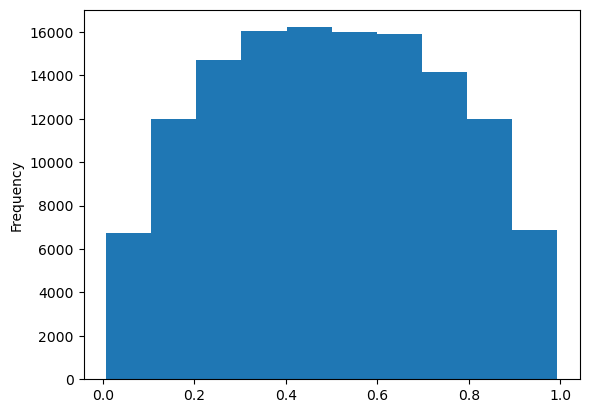

In [11]:
output["Pred"].plot.hist()
